### Test fit

In [2]:
from MCEq.core import config, MCEqRun
import crflux.models as crf
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
import sys
from scipy import stats
from scipy.stats import binom, poisson, norm
from iminuit import Minuit
import iminuit
from sympy.tensor.array import derive_by_array
from numpy import identity, array, dot, matmul
from latex2sympy2 import latex2sympy
from sympy import *
from time import time

sys.path.append('C:\\Users\\Bruger\\AppStat2021\\External_Functions')
import Clotilde_external_functions as cef
import ExternalFunctions as ef
from ExternalFunctions import nice_string_output, add_text_to_ax, UnbinnedLH

#sys.path.append('C:\\Users\\Bruger\\BSc_project')
import oscillation_prob as op
import own_oscillation_prob as oop

plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

## Honda fit with pseudo

Importing the oscillation code and running for values from http://www.nu-fit.org/?q=node/238

In [620]:
DM32_true = 2.51e-3
theta23_true = 42.1/180*np.pi
theta_maxmixing = 0.79689

print(np.sin(theta23_true))

0.6704266189587991


In [4]:
#t = time()
#prob_numu_to_numu_true, binned_prob_true = op.oscillation_prob(theta23_true, DM32_true)
#print(time() - t)

prob_numu_to_numu_true, binned_prob_true = oop.prob_numu_numu(theta23_true, DM32_true)

In [5]:
Honda_rate_cc = np.genfromtxt('Honda_rate_spline_cc', delimiter=',')
Honda_rate_nc = np.genfromtxt('Honda_rate_spline_nc', delimiter=',')

Honda_cc_oscillated = Honda_rate_cc * binned_prob_true
Honda_pseudo_data_cc = Honda_cc_oscillated.copy()

Honda_nc_oscillated = Honda_rate_nc * binned_prob_true
Honda_pseudo_data_nc = Honda_nc_oscillated.copy()

In [6]:
# Energy bins
energy_cropped = np.genfromtxt('energy_cropped')
energy_min = np.genfromtxt('numu_cc.csv', skip_header = 1, delimiter =',')[:,0]
energy_max = np.genfromtxt('numu_cc.csv', skip_header = 1, delimiter =',')[:,1]
energy_bins = np.digitize(energy_cropped, energy_min)
energy_binwidths = energy_max - energy_min

xticks = np.arange(-0.5, 10.5, 1)
energy_ticklabels = np.append(energy_min, energy_max[-1])
energy_strings = [f'{energy_ticklabels[i]}' for i in range(len(xticks))]

cos_values = np.round(np.arange(1, -1.1, -0.1), 2)
yticks = np.arange(-0.5, 20, 1)
ylabels = [f'{cos_values[i]}' for i in range(len(yticks))]

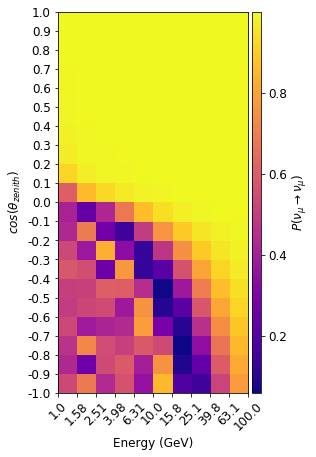

In [7]:
from matplotlib import cm, colors
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10,7))

im = ax.imshow(binned_prob_true, cmap='plasma')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im, cax=cax)
ax.set_xlabel('Energy (GeV)')
ax.set_ylabel(r'$cos(\theta_{zenith})$')
ax.set_xticks(xticks)
ax.set_xticklabels(energy_strings, rotation = 45)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)
cbar_label = r'$P(\nu_{\mu} \rightarrow \nu_{\mu})$'
cbar.set_label(cbar_label)

#### $\chi^2$ fit function

In [621]:

def chi_squared(fit_function, fit_rates, pseudo_data, fit_parameters, guesses):
    
    def chi2_owncalc(*fit_parameters):
        chi2_tot = np.zeros(len(fit_rates))
        
        for f in range(len(fit_rates)):
            _ , osc_prob = fit_function(*fit_parameters)
            fit_data = fit_rates[f] * osc_prob
            chi2 = np.sum(((pseudo_data[f] - fit_data)**2 / fit_data))
            chi2_tot[f] = chi2
        return np.sum(chi2_tot)

    chi2_owncalc.errordef = 1.0
    minuit = Minuit(chi2_owncalc, theta23 = guesses[0], DM32 = guesses[1] , name=('theta23', 'DM32')) #, limit=[(0, np.pi/2), None])
    minuit.limits['theta23'] = (0, theta_maxmixing)
    minuit.limits['DM32'] = (0.0023, 0.0027)
    minuit.tol = 0.00001
    minuit.migrad()
    
    Nvar = len(fit_parameters)               
    Ndof = 200 - Nvar
    
    Chi2_fit = minuit.fval          
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof)
    minuit.migrad()
    
    par = minuit.values[:]
    par_err = minuit.errors[:] 
    par_name = minuit.parameters[:]

    return Chi2_fit, Prob_fit, par, par_err

Fit of oscillated data to pseudo-data to get values of $\theta_{23}$ and $\Delta m_{32}^2$. 

### Asimov fits

In [9]:
Chi2_fit_Honda_cc, Prob_fit_Honda_cc, par_Honda_cc, par_err_Honda_cc = chi_squared(oop.prob_numu_numu, [Honda_rate_cc], [Honda_pseudo_data_cc], 
                                               ['theta23', 'DM32'], [theta23_true, DM32_true])

print('CC:')
print(f'theta23: {par_Honda_cc[0]}, DM32: {par_Honda_cc[1]}, chi^2: {Chi2_fit_Honda_cc}')
print(f'True values: theta23: {theta23_true}, DM32: {DM32_true}')

Chi2_fit_Honda_nc, Prob_fit_Honda_nc, par_Honda_nc, par_err_Honda_nc = chi_squared(oop.prob_numu_numu, [Honda_rate_nc], [Honda_pseudo_data_nc], 
                                               ['theta23', 'DM32'], [theta23_true, DM32_true])

print('NC:')
print(f'theta23: {par_Honda_nc[0]}, DM32: {par_Honda_nc[1]}, chi^2: {Chi2_fit_Honda_nc}')
print(f'True values: theta23: {theta23_true}, DM32: {DM32_true}')

CC:
theta23: 0.7347836150896128, DM32: 0.00251, chi^2: 0.0
True values: theta23: 0.7347836150896128, DM32: 0.00251
NC:
theta23: 0.7347836150896128, DM32: 0.00251, chi^2: 0.0
True values: theta23: 0.7347836150896128, DM32: 0.00251


In [10]:
# Combined fit of NC and CC

Chi2_fit_Honda_tot, Prob_fit_Honda_tot, par_Honda_tot, par_err_Honda_tot = chi_squared(oop.prob_numu_numu, [Honda_rate_cc, Honda_rate_nc], [Honda_pseudo_data_cc, Honda_pseudo_data_nc], 
                                               ['theta23', 'DM32'], [theta23_true, DM32_true])

print('CC:')
print(f'theta23: {par_Honda_cc[0]}, DM32: {par_Honda_cc[1]}, chi^2: {Chi2_fit_Honda_cc}')
print(f'True values: theta23: {theta23_true}, DM32: {DM32_true}')


CC:
theta23: 0.7347836150896128, DM32: 0.00251, chi^2: 0.0
True values: theta23: 0.7347836150896128, DM32: 0.00251


In [11]:
theta23_try = 0.74
DM32_try = 2e-3

Chi2_try_Honda_cc, Prob_fit_try_Honda_cc, par_try_Honda_cc, par_err_try_Honda_cc = chi_squared(oop.prob_numu_numu, [Honda_rate_cc], 
                                                               [Honda_pseudo_data_cc], ['theta23', 'DM32'], [theta23_try, DM32_try])
print('CC:')
print(f'theta23: {par_try_Honda_cc[0]}, DM32: {par_try_Honda_cc[1]}, chi^2: {Chi2_try_Honda_cc}')


Chi2_try_Honda_nc, Prob_fit_try_Honda_nc, par_try_Honda_nc, par_err_try_Honda_nc = chi_squared(oop.prob_numu_numu, [Honda_rate_nc], 
                                                               [Honda_pseudo_data_nc], ['theta23', 'DM32'], [theta23_try, DM32_try])

print('NC')
print(f'theta23: {par_try_Honda_nc[0]}, DM32: {par_try_Honda_nc[1]}, chi^2: {Chi2_try_Honda_nc}')

CC:
theta23: 0.6214304851662343, DM32: 0.0021572665988365985, chi^2: 1745.1161725973361
NC
theta23: 0.7347835983484594, DM32: 0.002509999995581932, chi^2: 4.06106849580713e-06


CC is more sensible to the guesses...

In [622]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

def asimov_fit(rates, pseudo, title, guesses, savefig=False, xrange_theta=None):
    
    chi2_array = np.zeros(len(guesses))
    theta23_fits = np.zeros(len(guesses))
    DM32_fits = np.zeros(len(guesses))
    
    for n in range(len(guesses)):

        Chi2_fluct, Prob_fit_fluct, par_fluct, par_err_fluct = chi_squared(oop.prob_numu_numu, rates, 
                                                                   pseudo, ['theta23', 'DM32'], 
                                                                       guesses[n])
        chi2_array[n] = Chi2_fluct
        theta23_fits[n] = par_fluct[0]
        DM32_fits[n] =  par_fluct[1]
        
    fig, axs = plt.subplots(1, 3, figsize=(15,7))
    axs.ravel()

    true_val = [theta23_true, DM32_true]
    x_labels = [r'$\theta_{23}$ (radians)', r'$\Delta m_{32}^2$ ($eV^2$)', r'$\chi^2$']

    height = len(guesses)/2

    for n in range(3):
        if n<2:
            axs[n].plot([true_val[n], true_val[n]], [0,height/2], 'r-', label='True value')
        #axs[n].set_ylim(0,height)
        axs[n].set_ylabel('Counts')
        axs[n].set_xlabel(x_labels[n])
        axs[n].ticklabel_format(style='plain')
        axs[n].xaxis.set_major_formatter(FormatStrFormatter('%.4f')) #ScalarFormatter(useOffset=False))
        
    if xrange_theta != None:
        theta23_fits = np.array([t for t in theta23_fits if t>xrange_theta[0] and t<xrange_theta[1]])

    x_theta, y_theta, sy_theta, binwidth_theta, theta23_mean, theta23_std = cef.make_hist(axs[0], theta23_fits, Nbins=20, loc_dic = (0.05, 0.8), 
                                                                                 label=(r'$\theta_{23}$ fit values', ''), errors = False)
    x_dm, y_dm, sy_dm, binwidth_dm, DM32_mean, DM32_std = cef.make_hist(axs[1], DM32_fits, Nbins=20, loc_dic = (0.05, 0.8), 
                                                                                 label=(r'$\Delta m_{32}^2$ fit values', ''),errors = False)
    cef.make_hist(axs[2], chi2_array, Nbins=20, loc_dic = (0.05, 0.85), label=(r'$\chi^2$ fit values', ''),
                  errors = False)
    #axs[1,0].hist(theta23_fits, bins= 20)
    #axs[1,1].hist(DM32_fits, bins=20)
    #axs[1,2].hist(chi2_array, bins=20)

    plt.suptitle(title, fontsize=20);
    fig.tight_layout(pad=5.0);
    plt.show()
    
    if savefig != False:
        fig.savefig(savefig)
    
    return theta23_fits, np.mean(theta23_fits), np.std(theta23_fits), DM32_fits, np.mean(DM32_fits), np.std(DM32_fits)

In [219]:
# More asimov tests for different guesses
theta_guess = np.linspace(0.2, 0.95, 100)  #(0.5, 0.9, 100)
DM_guess = np.linspace(0.001, 0.003, 100)
guesses = list(zip(theta_guess, DM_guess))

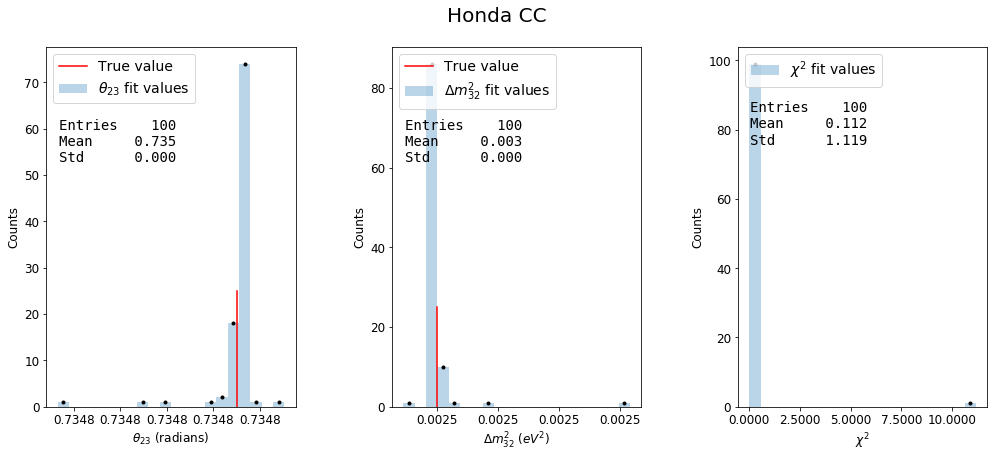

In [627]:
theta23_asimov_Honda_cc, theta23_asimov_mean_Honda_cc, theta23_asimov_std_Honda_cc, DM32_asimov_Honda_cc, DM32_asimov_mean_Honda_cc, DM32_asimov_std_Honda_cc = \
                                                                                                    asimov_fit([Honda_rate_cc], [Honda_pseudo_data_cc], 
                                                                                                               'Honda CC', guesses)#, xrange_theta=(0.7347, 0.737)) #,savefig='Honda_asimov_cc_lowtol')


In [617]:
DM32_asimov_Honda_cc

array([0.00088, 0.00088, 0.00088, 0.00088, 0.00088, 0.00088, 0.00088, 0.00088, 0.00088, 0.00088, 0.00088, 0.00251, 0.00251, 0.00251, 0.00251,
       0.00251, 0.00216, 0.00251, 0.00216, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00216,
       0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00216, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251,
       0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00216, 0.00251, 0.00251, 0.00216, 0.00216, 0.00216, 0.00216, 0.00216, 0.00216, 0.00216,
       0.00216, 0.00216, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251,
       0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251,
       0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251, 0.00251])

In [170]:
# different in 9th decimal
print(['%.10f' % np.sort(theta23_asimov_Honda_cc)[i] for i in range(100)])  #true: 0.7347836151

['0.7347836146', '0.7347836147', '0.7347836147', '0.7347836147', '0.7347836147', '0.7347836148', '0.7347836148', '0.7347836149', '0.7347836149', '0.7347836150', '0.7347836150', '0.7347836150', '0.7347836151', '0.7347836151', '0.7347836152', '0.7347836153', '0.7347836153', '0.7347836155', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347836157', '0.7347

In [217]:
z_theta_mean_asimov = abs((theta23_asimov_mean_Honda_cc - theta23_true)/theta23_asimov_std_Honda_cc)
z_DM_mean_asimov = abs((DM32_asimov_mean_Honda_cc - DM32_true))/DM32_asimov_std_Honda_cc
print(z_theta_mean_asimov, z_DM_mean_asimov)

1.5964838554951288 0.10747677721237195


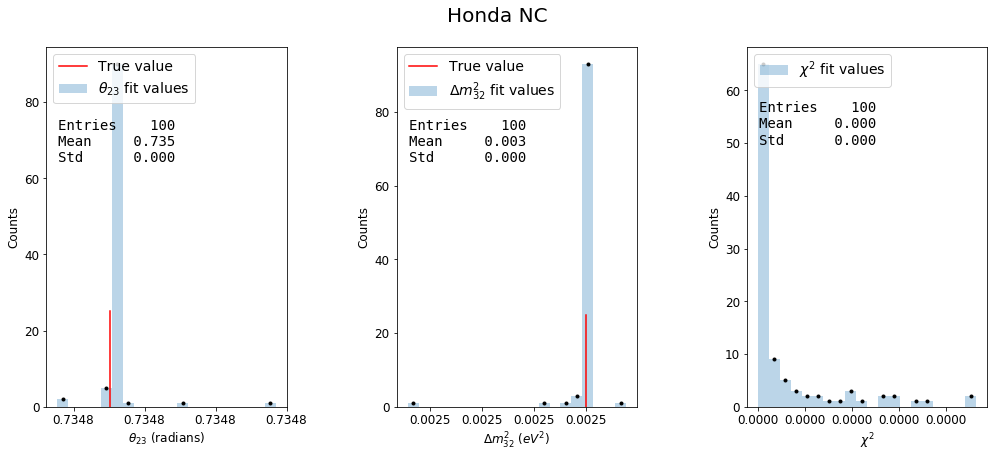

In [624]:
theta23_asimov_Honda_nc, theta23_asimov_mean_Honda_nc, theta23_asimov_std_Honda_nc, DM32_asimov_Honda_nc, DM32_asimov_mean_Honda_nc, DM32_asimov_std_Honda_nc = \
                                                                                                    asimov_fit([Honda_rate_nc], [Honda_pseudo_data_nc], 'Honda NC', guesses)


In [84]:
#theta23_asimov_Honda_nc

In [356]:
z_theta_mean_asimov_nc = abs((theta23_asimov_mean_Honda_nc - theta23_true)/theta23_asimov_std_Honda_nc)
z_DM_mean_asimov_nc = abs((DM32_asimov_mean_Honda_nc - DM32_true))/DM32_asimov_std_Honda_nc
print(z_theta_mean_asimov_nc, z_DM_mean_asimov_nc)

0.44313564355938906 5.915165159719014e-11


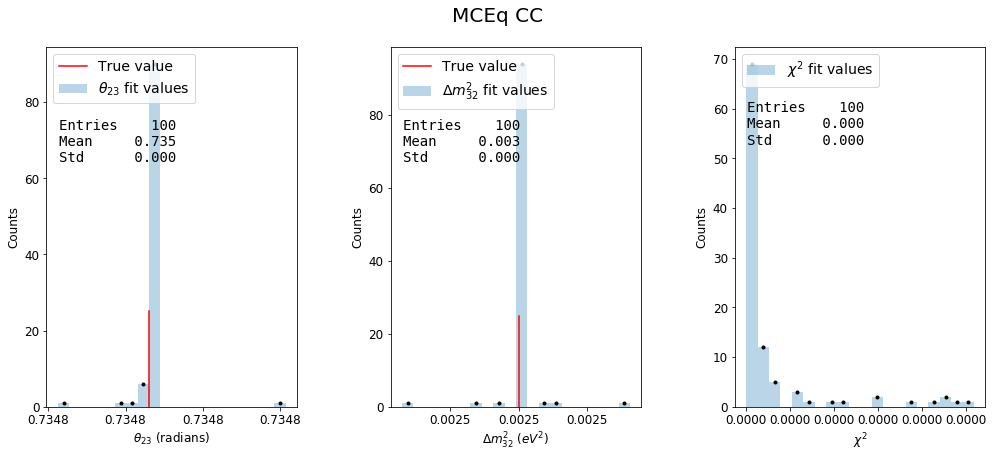

In [625]:
theta23_asimov_MCEq_cc, theta23_asimov_mean_MCEq_cc, theta23_asimov_std_MCEq_cc, DM32_asimov_MCEq_cc, DM32_asimov_mean_MCEq_cc, DM32_asimov_std_MCEq_cc = \
                                                                                                    asimov_fit([MCEq_rate_cc], [MCEq_pseudo_data_cc], 'MCEq CC', guesses) #, savefig='Honda_asimov_cc_bad_guess')


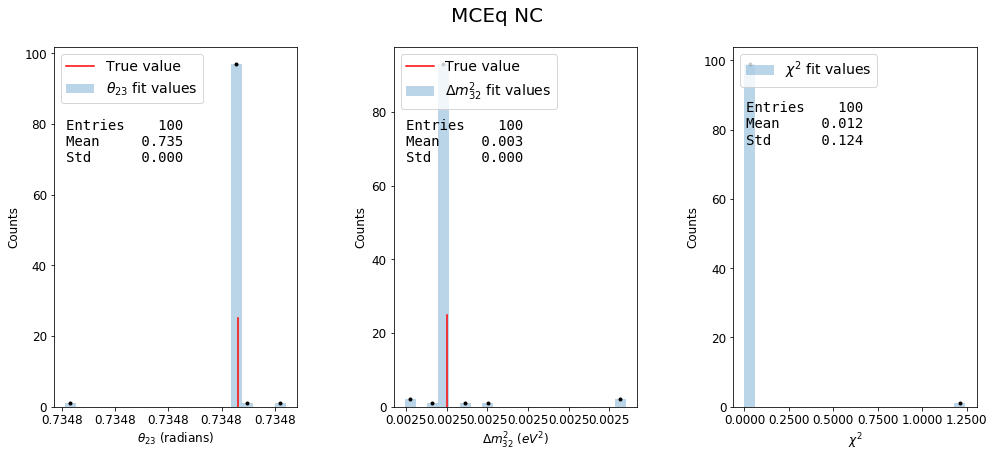

In [626]:
theta23_asimov_MCEq_nc, theta23_asimov_mean_MCEq_nc, theta23_asimov_std_MCEq_nc, DM32_asimov_MCEq_nc, DM32_asimov_mean_MCEq_nc, DM32_asimov_std_MCEq_nc = \
                                                                                                    asimov_fit([MCEq_rate_nc], [MCEq_pseudo_data_nc], 'MCEq NC', guesses) #, savefig='Honda_asimov_cc')


In [383]:
def find_nearest_above(my_array, target):
    
    diff = my_array - target
    mask = np.ma.less_equal(diff, 0)
    
    if np.all(mask):
        return None 
    masked_diff = np.ma.masked_array(diff, mask)
    
    return masked_diff.argmin()

In [570]:
N_landscape = 50
theta23_landscape_Honda_cc_asimov = np.linspace(0.65, 1.1, N_landscape)
DM32_landscape_Honda_cc_asimov = np.linspace(np.sort(DM32_fits_Honda_cc)[0], np.sort(DM32_fits_Honda_cc)[-1], N_landscape)

theta23_landscape_Honda_nc_asimov = np.linspace(0.65, 1.1, N_landscape)
DM32_landscape_Honda_nc_asimov = np.linspace(np.sort(DM32_fits_Honda_nc)[0], np.sort(DM32_fits_Honda_nc)[-1], N_landscape)
    
chi2_landscape_values_Honda_cc_asimov = np.zeros((N_landscape, N_landscape))
chi2_landscape_values_Honda_nc_asimov = np.zeros((N_landscape, N_landscape))

for t in range(N_landscape):
    for m in range(N_landscape):
        chi2_landscape_values_Honda_cc_asimov[m, t] = chi2_landscape(Honda_rate_cc, Honda_pseudo_data_cc, theta23_landscape_Honda_cc_asimov[t], DM32_landscape_Honda_cc_asimov[m])
        chi2_landscape_values_Honda_nc_asimov[m, t] = chi2_landscape(Honda_rate_nc, Honda_pseudo_data_nc, theta23_landscape_Honda_nc_asimov[t], DM32_landscape_Honda_nc_asimov[m])


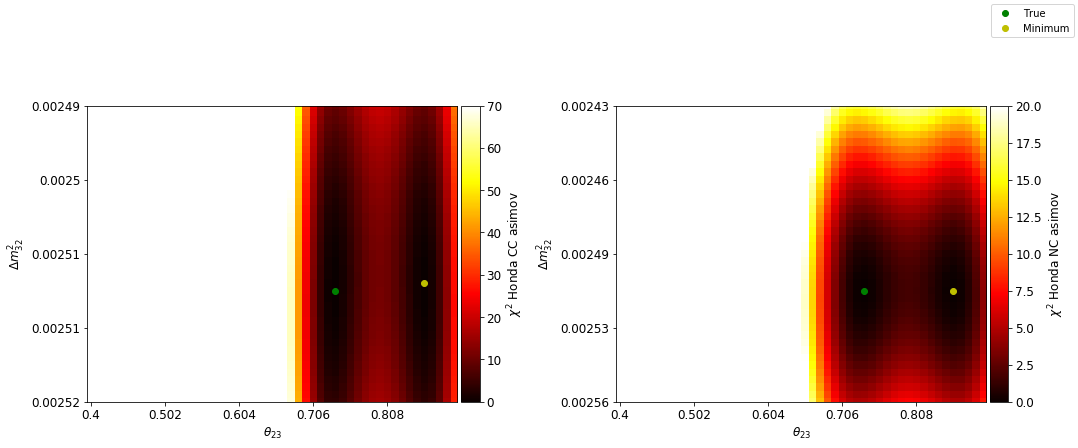

In [613]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))
ax.ravel()

im_cc = ax[0].imshow(chi2_landscape_values_Honda_cc_asimov, cmap='hot', vmin=0, vmax=70)
divider_cc = make_axes_locatable(ax[0])
cax_cc = divider_cc.append_axes("right", size="5%", pad=0.05)
cbar_cc = plt.colorbar(im_cc, cax=cax_cc)
cbar_cc.set_label(r'$\chi^2$ Honda CC asimov')

#chi2_landscape_values_Honda_nc_plot = chi2_landscape_values_Honda_nc.copy()[:,10:25]

im_nc = ax[1].imshow(chi2_landscape_values_Honda_nc_asimov, cmap='hot', vmin=0, vmax=20)
divider_nc = make_axes_locatable(ax[1])
cax_nc = divider_nc.append_axes("right", size="5%", pad=0.05)
cbar_nc = plt.colorbar(im_nc, cax=cax_nc)
cbar_nc.set_label(r'$\chi^2$ Honda NC asimov')

ax[0].plot(find_nearest_above(theta23_landscape_Honda_cc_asimov, theta23_true), find_nearest_above(DM32_landscape_Honda_cc_asimov, DM32_true), 'go', label='True')
ax[1].plot(find_nearest_above(theta23_landscape_Honda_nc_asimov, theta23_true), find_nearest_above(DM32_landscape_Honda_nc_asimov, DM32_true), 'go')

chi2_Honda_cc_min_asimov = np.unravel_index(chi2_landscape_values_Honda_cc_asimov.argmin(), chi2_landscape_values_Honda_cc_asimov.shape)
chi2_Honda_nc_min_asimov = np.unravel_index(chi2_landscape_values_Honda_nc_asimov.argmin(), chi2_landscape_values_Honda_nc_asimov.shape)

ax[0].plot(chi2_Honda_cc_min_asimov[1], chi2_Honda_cc_min_asimov[0], 'yo', label='Minimum')
ax[1].plot(chi2_Honda_nc_min_asimov[1], chi2_Honda_nc_min_asimov[0], 'yo')


for n in range(2):
    ax[n].set_xlabel(r'$\theta_{23}$')
    ax[n].set_ylabel(r'$\Delta m^2_{32}$')
    ax[n].set_xticks(np.arange(0,N_landscape, 10))
    ax[n].set_yticks(np.arange(0,N_landscape, 10))
    

ax[0].set_xticklabels([f'{np.round(theta23_landscape_Honda_cc_asimov[i], 3)}' for i in np.arange(0,N_landscape, 10)])
ax[0].set_yticklabels([f'{np.round(DM32_landscape_Honda_cc_asimov[i], 5)}' for i in np.arange(0,N_landscape, 10)])
ax[1].set_xticklabels([f'{np.round(theta23_landscape_Honda_nc_asimov[i], 3)}' for i in np.arange(0,N_landscape, 10)])
ax[1].set_yticklabels([f'{np.round(DM32_landscape_Honda_nc_asimov[i], 5)}' for i in np.arange(0,N_landscape, 10)])
plt.tight_layout()
fig.legend()
#fig.savefig('Honda_asimov_chi2_landscape');

In [576]:
theta23_min_Honda_cc_asimov = theta23_landscape_Honda_cc_asimov[chi2_Honda_cc_min_asimov[1]]
DM32_min_Honda_cc_asimov = DM32_landscape_Honda_cc_asimov[chi2_Honda_cc_min_asimov[0]]

theta23_min_Honda_nc_asimov = theta23_landscape_Honda_nc_asimov[chi2_Honda_nc_min_asimov[1]]
DM32_min_Honda_nc_asimov = DM32_landscape_Honda_nc_asimov[chi2_Honda_nc_min_asimov[0]]

In [578]:
print(theta23_min_Honda_cc_asimov, theta23_min_Honda_nc_asimov)

0.8591836734693877 0.8591836734693877


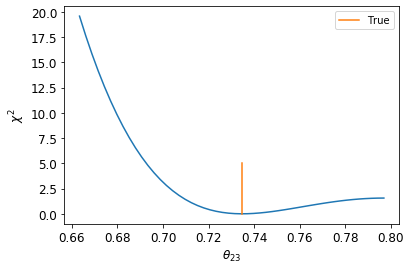

In [397]:
plt.plot(theta23_landscape_Honda_nc_asimov, chi2_landscape_values_Honda_nc_asimov[find_nearest_above(DM32_landscape_Honda_nc_asimov, DM32_true),:])
plt.xlabel(r'$\theta_{23}$')
plt.ylabel(r'$\chi^2$')
plt.plot([theta23_true, theta23_true], [0,5], label='True')
plt.legend();

In [619]:
chi2_Honda_cc_asimov_wrong = [np.zeros((N_landscape, N_landscape)), np.zeros((N_landscape, N_landscape)), np.zeros((N_landscape, N_landscape))]
chi2_Honda_nc_asimov_wrong = [np.zeros((N_landscape, N_landscape)), np.zeros((N_landscape, N_landscape)), np.zeros((N_landscape, N_landscape))]

theta23_dist =  np.array([0.2, 0.1, 0.05])
theta23_wrong = theta_maxmixing - theta23_dist

theta23_wrong_labels = []

for n in range(len(theta23_wrong)):
    _, binned_prob_wrong = oop.prob_numu_numu(theta23_wrong[n], DM32_true)
    Honda_pseudo_cc_wrong = Honda_rate_cc * binned_prob_wrong
    Honda_pseudo_nc_wrong = Honda_rate_nc * binned_prob_wrong
    theta23_landscape_wrong = np.linspace(theta23_wrong[n] - 0.05, (theta_maxmixing + theta23_dist)[n] +0.05 , N_landscape)
    theta23_wrong_labels.append(theta23_landscape_wrong)
    
    for t in range(N_landscape):
        for m in range(N_landscape):
            chi2_Honda_cc_asimov_wrong[n][m, t] = chi2_landscape(Honda_rate_cc, Honda_pseudo_cc_wrong, theta23_landscape_wrong[t], DM32_landscape_Honda_cc_asimov[m])
            chi2_Honda_nc_asimov_wrong[n][m, t] = chi2_landscape(Honda_rate_nc, Honda_pseudo_nc_wrong, theta23_landscape_wrong[t], DM32_landscape_Honda_nc_asimov[m])

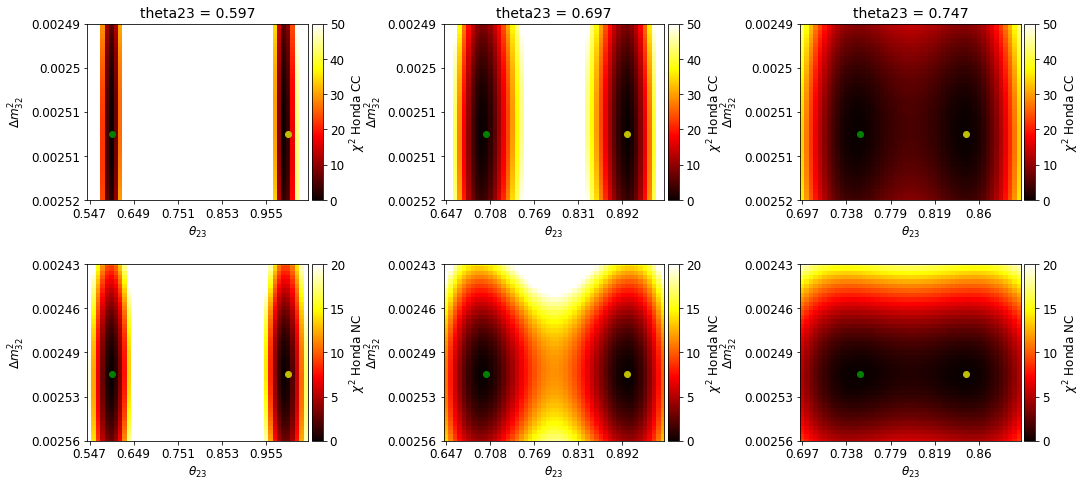

In [616]:
fig, ax = plt.subplots(2, 3, figsize=(15,7))
ax.ravel()

for i in range(3):

    im_cc = ax[0, i].imshow(chi2_Honda_cc_asimov_wrong[i], cmap='hot', vmin=0, vmax=50)
    divider_cc = make_axes_locatable(ax[0, i])
    cax_cc = divider_cc.append_axes("right", size="5%", pad=0.05)
    cbar_cc = plt.colorbar(im_cc, cax=cax_cc)
    cbar_cc.set_label(r'$\chi^2$ Honda CC')

    im_nc = ax[1, i].imshow(chi2_Honda_nc_asimov_wrong[i], cmap='hot', vmin=0, vmax=20)
    divider_nc = make_axes_locatable(ax[1, i])
    cax_nc = divider_nc.append_axes("right", size="5%", pad=0.05)
    cbar_nc = plt.colorbar(im_nc, cax=cax_nc)
    cbar_nc.set_label(r'$\chi^2$ Honda NC')

    ax[0, i].plot(find_nearest_above(theta23_wrong_labels[i], theta23_wrong[i]), find_nearest_above(DM32_landscape_Honda_cc_asimov, DM32_true), 'go')
    ax[1, i].plot(find_nearest_above(theta23_wrong_labels[i], theta23_wrong[i]), find_nearest_above(DM32_landscape_Honda_nc_asimov, DM32_true), 'go')

    chi2_Honda_cc_min_wrong = np.unravel_index(chi2_Honda_cc_asimov_wrong[i][:,30:].argmin(), chi2_Honda_cc_asimov_wrong[i][:,30:].shape)
    chi2_Honda_nc_min_wrong = np.unravel_index(chi2_Honda_nc_asimov_wrong[i][:,30:].argmin(), chi2_Honda_nc_asimov_wrong[i][:,30:].shape)
    
    ax[0, i].plot(find_nearest_above(theta23_wrong_labels[i], (theta_maxmixing + theta23_dist)[i]), find_nearest_above(DM32_landscape_Honda_cc_asimov, DM32_true), 'yo')
    ax[1, i].plot(find_nearest_above(theta23_wrong_labels[i], (theta_maxmixing + theta23_dist)[i]), find_nearest_above(DM32_landscape_Honda_nc_asimov, DM32_true), 'yo')


for n in range(2):
    for m in range(3):
        ax[n, m].set_xlabel(r'$\theta_{23}$')
        ax[n, m].set_ylabel(r'$\Delta m^2_{32}$')
        ax[n, m].set_xticks(np.arange(0,N_landscape, 10))
        ax[n, m].set_yticks(np.arange(0,N_landscape, 10))
    

        ax[0, m].set_xticklabels([f'{np.round(theta23_wrong_labels[m][i], 3)}' for i in np.arange(0,N_landscape, 10)])
        ax[0, m].set_yticklabels([f'{np.round(DM32_landscape_Honda_cc_asimov[i], 5)}' for i in np.arange(0,N_landscape, 10)])
        ax[1, m].set_xticklabels([f'{np.round(theta23_wrong_labels[m][i], 3)}' for i in np.arange(0,N_landscape, 10)])
        ax[1, m].set_yticklabels([f'{np.round(DM32_landscape_Honda_nc_asimov[i], 5)}' for i in np.arange(0,N_landscape, 10)])
        
        ax[0, m].set_title(f'theta23 = {np.round(theta23_wrong[m],3)}')

plt.tight_layout()
#fig.legend()
#fig.savefig('chi2_landscape_wrong_theta');

### With fluctuations

In [628]:
# new pseudo-data with fluctuations
r = np.random
Honda_pseudo_fluctuation_cc = r.poisson(Honda_pseudo_data_cc)
Honda_pseudo_fluctuation_nc = r.poisson(Honda_pseudo_data_nc)

Chi2_fluct_Honda_cc, Prob_fit_fluct_Honda_cc, par_fluct_Honda_cc, par_err_fluct_Honda_cc = chi_squared(oop.prob_numu_numu, [Honda_rate_cc], 
                                                               [Honda_pseudo_fluctuation_cc], ['theta23', 'DM32'], 
                                                                   [theta23_true, DM32_true])

print('CC')
print(f'theta23: {par_fluct_Honda_cc[0]}, DM32: {par_fluct_Honda_cc[1]}, chi^2: {Chi2_fluct_Honda_cc}')

Chi2_fluct_Honda_nc, Prob_fit_fluct_Honda_nc, par_fluct_Honda_nc, par_err_fluct_Honda_nc = chi_squared(oop.prob_numu_numu, [Honda_rate_nc], 
                                                               [Honda_pseudo_fluctuation_nc], ['theta23', 'DM32'], 
                                                                   [theta23_true, DM32_true])

print('NC')
print(f'theta23: {par_fluct_Honda_nc[0]}, DM32: {par_fluct_Honda_nc[1]}, chi^2: {Chi2_fluct_Honda_nc}')

CC
theta23: 0.7234650278730295, DM32: 0.00251514425092694, chi^2: 206.46918536064217
NC
theta23: 0.7091080755895349, DM32: 0.002481887362892387, chi^2: 175.60258032935565


In [15]:
# CC
z_theta = abs((par_fluct_Honda_cc[0] - theta23_true)/np.sqrt(par_err_fluct_Honda_cc[0]**2 + (1*np.pi/180)**2))
z_DM = abs((par_fluct_Honda_cc[1] - DM32_true)/np.sqrt(par_err_fluct_Honda_cc[1]**2 + (0.027e-3)**2))
print(z_theta, z_DM)

1.0811175321667557 0.0546052885634254


theta23: 0.7325809647388495, DM32: 0.002524803889096568, chi^2: 159.80265729623454


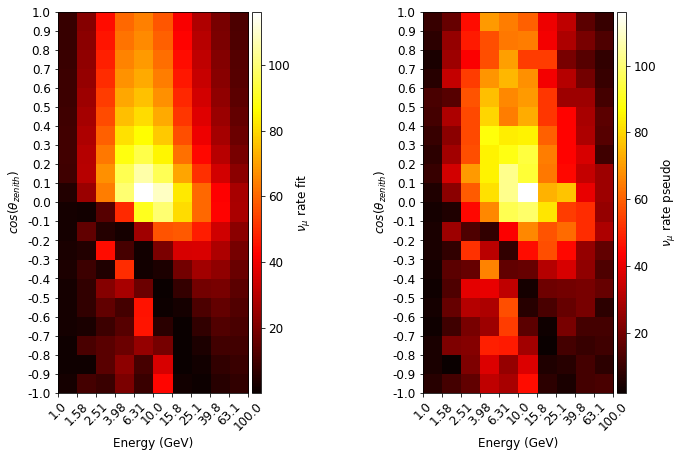

theta23: -0.923427342479556, DM32: 0.0024899860998045618, chi^2: 154.74708335907297


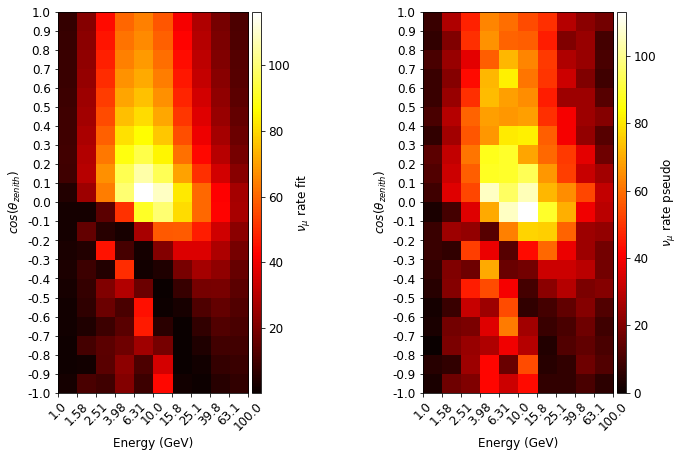

In [61]:

for n in range(1000):
    r = np.random
    Honda_pseudo_fluctuation_nc = r.poisson(Honda_pseudo_data_nc)

    Chi2_fluct, Prob_fit_fluct, par_fluct, par_err_fluct = chi_squared(oop.prob_numu_numu, [Honda_rate_nc], 
                                                                   [Honda_pseudo_fluctuation_nc], ['theta23', 'DM32'], 
                                                                       [theta23_true, DM32_true])
    
    if n==0 or par_fluct[0]<0:

        print(f'theta23: {par_fluct[0]}, DM32: {par_fluct[1]}, chi^2: {Chi2_fluct}')

        prob_numu_to_numu, osc_prob_binned = oop.prob_numu_numu(par_fluct[0], par_fluct[1])
        fit_data = Honda_pseudo_data_nc * osc_prob_binned

        fig, ax = plt.subplots(1, 2, figsize=(12,7))
        ax.ravel()

        im0 = ax[0].imshow(fit_data, cmap='hot')
        divider0 = make_axes_locatable(ax[0])
        cax0 = divider0.append_axes("right", size="5%", pad=0.05)
        cbar0 = plt.colorbar(im0, cax=cax0)
        ax[0].set_xlabel('Energy (GeV)')
        ax[0].set_ylabel(r'$cos(\theta_{zenith})$')
        ax[0].set_xticks(xticks)
        ax[0].set_xticklabels(energy_strings, rotation = 45)
        ax[0].set_yticks(yticks)
        ax[0].set_yticklabels(ylabels)
        cbar_label0 = r'$\nu_{\mu}$ rate fit'
        cbar0.set_label(cbar_label0)

        im1 = ax[1].imshow(Honda_pseudo_fluctuation_nc, cmap='hot')
        divider1 = make_axes_locatable(ax[1])
        cax1 = divider1.append_axes("right", size="5%", pad=0.05)
        cbar1 = plt.colorbar(im1, cax=cax1)
        ax[1].set_xlabel('Energy (GeV)')
        ax[1].set_ylabel(r'$cos(\theta_{zenith})$')
        ax[1].set_xticks(xticks)
        ax[1].set_xticklabels(energy_strings, rotation = 45)
        ax[1].set_yticks(yticks)
        ax[1].set_yticklabels(ylabels)
        cbar_label1 = r'$\nu_{\mu}$ rate pseudo'
        cbar1.set_label(cbar_label1)
        plt.show()
        
        if par_fluct[0]<0:
            break

In [655]:
# function for multiple fits

def fit_hist(N, rates, pseudo, title, fluct = 'poisson', guess =[theta23_true, DM32_true], savefig = False):
    
    chi2_array = np.zeros(N)
    theta23_fits = np.zeros(N)
    DM32_fits = np.zeros(N)
    
    for n in range(N):
        if fluct == 'poisson':
            pseudo_fluct = r.poisson(pseudo) 
            
        elif fluct == 'gauss':
            pseudo_fluct = r.normal(loc=pseudo, scale=np.sqrt(pseudo))
            
        elif fluct == 'uniform':
            pseudo_fluct = pseudo + r.uniform(-np.sqrt(pseudo), np.sqrt(pseudo))

            
        Chi2_fluct, Prob_fit_fluct, par_fluct, par_err_fluct = chi_squared(oop.prob_numu_numu, rates, 
                                                                   pseudo_fluct, ['theta23', 'DM32'], 
                                                                       guess)
        chi2_array[n] = Chi2_fluct
        theta23_fits[n] = par_fluct[0]
        DM32_fits[n] =  par_fluct[1]
        
    fig, axs = plt.subplots(1,3, figsize=(15,7))
    axs.ravel()

    true_val = [theta23_true, DM32_true]
    x_labels = [r'$\theta_{23}$ (radians)', r'$\Delta m_{32}^2$ ($eV^2$)', r'$\chi^2$']

    height = N/4

    for n in range(3):
        if n<2:
            axs[n].plot([true_val[n], true_val[n]], [0,height/2], 'r-', label='True value')
        axs[n].set_ylim(0,height)
        axs[n].set_ylabel('Counts')
        axs[n].set_xlabel(x_labels[n])

    x_theta, y_theta, sy_theta, binwidth_theta, theta23_mean, theta23_std = cef.make_hist(axs[0], theta23_fits, Nbins=20, loc_dic = (0.05, 0.8), 
                                                                                 label=(r'$\theta_{23}$ fit values', ''), errors = False)
    x_dm, y_dm, sy_dm, binwidth_dm, DM32_mean, DM32_std = cef.make_hist(axs[1], DM32_fits, Nbins=20, loc_dic = (0.05, 0.8), 
                                                                                 label=(r'$\Delta m_{32}^2$ fit values', ''),errors = False)
    cef.make_hist(axs[2], chi2_array, Nbins=20, loc_dic = (0.05, 0.85), label=(r'$\chi^2$ fit values', ''),
                  errors = False)

    plt.suptitle(title, fontsize=20);
    fig.tight_layout(pad=5.0);
    
    if savefig != False:
        fig.savefig(savefig)
    
    return theta23_fits, theta23_mean, theta23_std, DM32_fits, DM32_mean, DM32_std

129.3699827194214


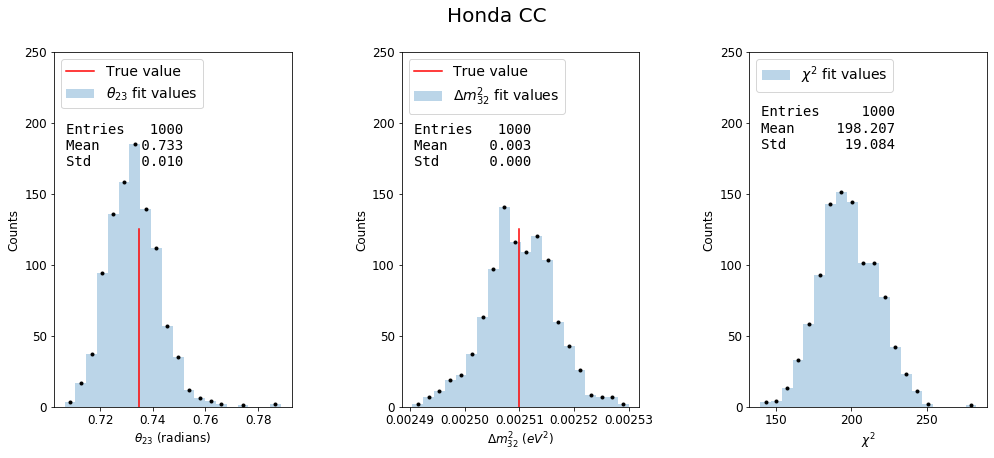

In [659]:
from time import time

t = time()
N_runs = 1000
theta23_fits_Honda_cc, theta23_mean_Honda_cc, theta23_std_Honda_cc, DM32_fits_Honda_cc, DM32_mean_Honda_cc, DM32_std_Honda_cc = \
                                                                                                    fit_hist(N_runs, \
                                                                                                    [Honda_rate_cc], \
                                                                                                    [Honda_pseudo_data_cc], \
                                                                                                    'Honda CC') #, savefig='Honda_cc_fits')
print(time()-t)

In [193]:
# tol = 2: time: 78 s, bias - z_theta = 0.26
# tol = 0.0001: time: 100 s, bias - z_theta = 0.32

0.7347836150896128


In [648]:
z_theta_mean = abs((theta23_mean_Honda_cc - theta23_true)/theta23_std_Honda_cc)
z_DM_mean = abs((DM32_mean_Honda_cc - DM32_true))/DM32_std_Honda_cc
skew_cc = (theta23_mean_Honda_cc - st.mode(theta23_fits_Honda_cc)[0][0]) / theta23_std_Honda_cc
print(z_theta_mean, z_DM_mean, skew_cc)

0.1676037269943611 0.048913655390967314 3.2560957201463867


In [649]:
# Fractions of points within 1, 2, 3 sigmas
npoints_1d_sigma_theta23 = [0, 0, 0]
npoints_1d_sigma_DM32 = [0, 0, 0]

for i in range(N_runs):
    for n in range(1,4):
        
        if theta23_fits_Honda_cc[i] < theta23_mean_Honda_cc + n*theta23_std_Honda_cc \
            and theta23_fits_Honda_cc[i] > theta23_mean_Honda_cc - n*theta23_std_Honda_cc:
            npoints_1d_sigma_theta23[n-1] += 1
            
        if DM32_fits_Honda_cc[i] < DM32_mean_Honda_cc + n*DM32_std_Honda_cc \
            and DM32_fits_Honda_cc[i] > DM32_mean_Honda_cc - n*DM32_std_Honda_cc:
            npoints_1d_sigma_DM32[n-1] += 1

sigma_fractions = [0.68, 0.95, 0.997]
for n in range(1,4):
    print('1 sigma of 1000 points:', int(1000*sigma_fractions[n-1]))
    print(f'theta23 fraction of points within', n ,'sigma:', npoints_1d_sigma_theta23[n-1], '+/-', int(np.sqrt(npoints_1d_sigma_theta23[n-1])+0.5))
    print(f'DM32 fraction of points within', n ,'sigma:', npoints_1d_sigma_DM32[n-1], '+/-', int(np.sqrt(npoints_1d_sigma_DM32[n-1])+0.5))

1 sigma of 1000 points: 680
theta23 fraction of points within 1 sigma: 693 +/- 26
DM32 fraction of points within 1 sigma: 685 +/- 26
1 sigma of 1000 points: 950
theta23 fraction of points within 2 sigma: 955 +/- 31
DM32 fraction of points within 2 sigma: 953 +/- 31
1 sigma of 1000 points: 997
theta23 fraction of points within 3 sigma: 993 +/- 32
DM32 fraction of points within 3 sigma: 997 +/- 32


In [650]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# confidence intervals

def confidence_ellipse(x, y, ax, n_std, facecolor='none', **kwargs):
    # from https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
    
    
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)      #why?
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0,0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    # why rotate?

    ellipse.set_transform(transf + ax.transData)  # what?
    ellipse_plot = ax.add_patch(ellipse)
    
    return ellipse, ellipse_plot

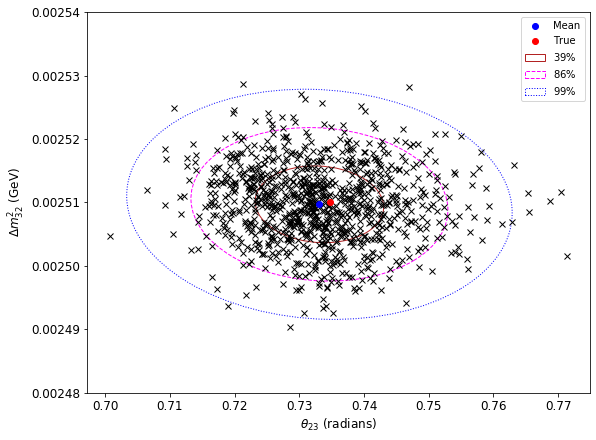

In [651]:
fig, ax = plt.subplots(figsize=(9, 7))

mu_Honda_cc = theta23_mean_Honda_cc, DM32_mean_Honda_cc
scale_Honda_cc = theta23_std_Honda_cc, DM32_std_Honda_cc

ax.plot(theta23_fits_Honda_cc, DM32_fits_Honda_cc, 'kx')

sigma1_contour_Honda_cc, _ = confidence_ellipse(theta23_fits_Honda_cc, DM32_fits_Honda_cc, ax, n_std=1,
                                                label=r'$39\%$', edgecolor='firebrick')
sigma2_contour_Honda_cc, _ = confidence_ellipse(theta23_fits_Honda_cc, DM32_fits_Honda_cc, ax, n_std=2,
                                                label=r'$86\%$', edgecolor='fuchsia', linestyle='--')
sigma3_contour_Honda_cc, _ = confidence_ellipse(theta23_fits_Honda_cc, DM32_fits_Honda_cc, ax, n_std=3,
                                                label=r'$99\%$', edgecolor='blue', linestyle=':')

ax.plot(mu_Honda_cc[0], mu_Honda_cc[1], 'bo', label='Mean')
ax.plot(theta23_true, DM32_true, 'ro', label='True')

ax.legend()
ax.set_ylim(0.00248, 0.00254)
ax.set_xlabel(r'$\theta_{23}$ (radians)')
ax.set_ylabel(r'$\Delta m_{32}^2$ (GeV)')
#fig.savefig('Honda_cc_confidence')
plt.show()

In [177]:
# Check how many points are within the 1 sigma, 2 sigma contours
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4358977/ Confidence levels for different dimensionality of a Gaussian

fit_points = list(zip(theta23_fits_Honda_cc, DM32_fits_Honda_cc))

n_points_sigma1 = 0
n_points_sigma2 = 0
n_points_sigma3 = 0

for p in fit_points:
    within_sigma1 = sigma1_contour_Honda_cc.contains_point(ax.transData.transform(p))              
    if within_sigma1:
        n_points_sigma1 += 1
        
    within_sigma2 = sigma2_contour_Honda_cc.contains_point(ax.transData.transform(p))              
    if within_sigma2:
        n_points_sigma2 += 1
        
    within_sigma3 = sigma3_contour_Honda_cc.contains_point(ax.transData.transform(p))              
    if within_sigma3:
        n_points_sigma3 += 1
        
print(f'Fraction of points within 39%-contour: {n_points_sigma1}', '+/-', int(np.sqrt(n_points_sigma1)+0.5))
print(f'Fraction of points within 86%-contour: {n_points_sigma2}', '+/-', int(np.sqrt(n_points_sigma2)+0.5))
print(f'Fraction of points within 99%-contour: {n_points_sigma3}', '+/-', int(np.sqrt(n_points_sigma3)+0.5))

Fraction of points within 39%-contour: 401 +/- 20
Fraction of points within 86%-contour: 863 +/- 29
Fraction of points within 99%-contour: 992 +/- 31


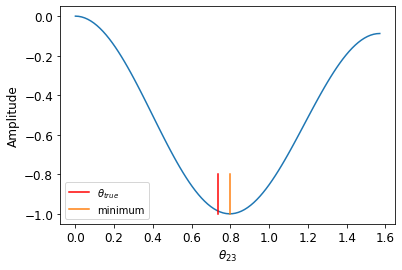

In [615]:
theta13 =  8.62/180 * np.pi

def A(theta23):
    x = np.sin(theta23)**2 *np.cos(theta13)**2
    amp = 4*x**2 - 4*x
    return amp

x = np.linspace(0,1,100)
thetas = np.linspace(0,np.pi/2, 100)
plt.plot(thetas, A(thetas))
plt.plot([theta23_true, theta23_true], [-1,-0.8], 'r-', label=r'$\theta_{true}$')
plt.plot([theta_maxmixing, theta_maxmixing], [-1,-0.8], label='minimum')
plt.xlabel(r'$\theta_{23}$')
plt.ylabel('Amplitude')
plt.legend()
plt.savefig('P_amplitude');

In [581]:
print(theta23_min_Honda_nc_asimov - theta_maxmixing, theta_maxmixing - theta23_true)

0.062293673469387745 0.062106384910387225


In [154]:

print(np.arcsin(np.sqrt(1/2/np.cos(theta13)**2)))
print(np.sin(theta23_true)**2 *np.cos(theta13)**2)

0.7968893709850228
0.4393748452117815


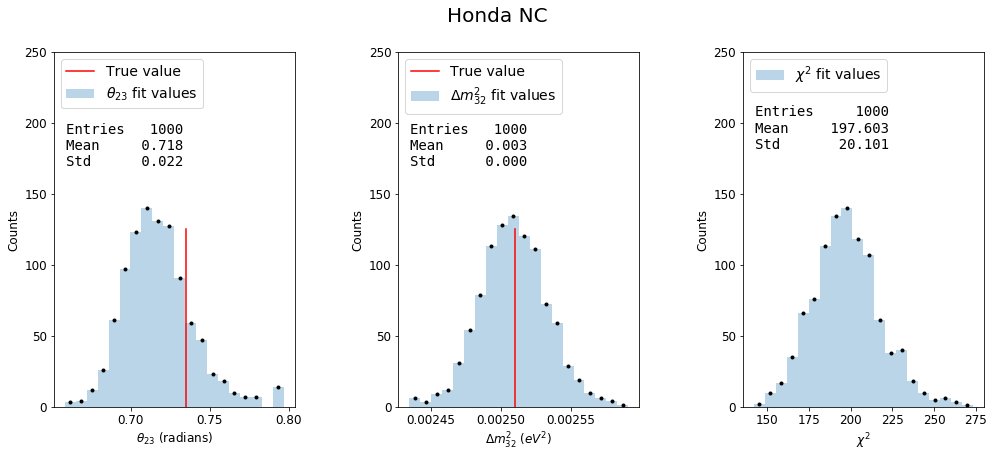

In [632]:
theta23_fits_Honda_nc_poisson, theta23_mean_Honda_nc_poisson, theta23_std_Honda_nc_poisson, \
DM32_fits_Honda_nc_poisson, DM32_mean_Honda_nc_poisson, DM32_std_Honda_nc_poisson = \
                                                                            fit_hist(N_runs, \
                                                                            [Honda_rate_nc], \
                                                                            [Honda_pseudo_data_nc], \
                                                                            title = 'Honda NC poisson',\
                                                                            fluct = 'poisson')

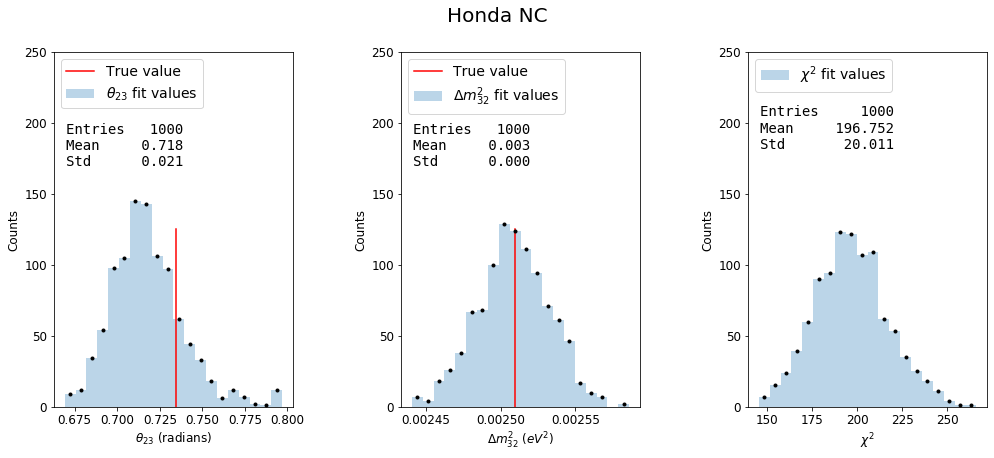

In [633]:
theta23_fits_Honda_nc_normal, theta23_mean_Honda_nc_normal, theta23_std_Honda_nc_normal, \
DM32_fits_Honda_nc_normal, DM32_mean_Honda_nc_normal, DM32_std_Honda_nc_normal = \
                                                                            fit_hist(N_runs, \
                                                                            [Honda_rate_nc], \
                                                                            [Honda_pseudo_data_nc], \
                                                                            title = 'Honda NC gauss',\
                                                                            fluct = 'gauss') #, savefig='Honda_nc_fits')

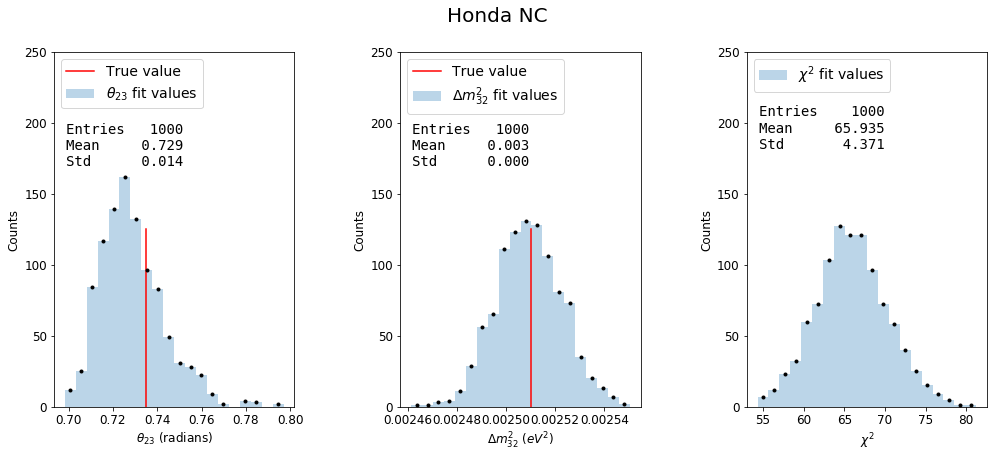

In [634]:
theta23_fits_Honda_nc_uniform, theta23_mean_Honda_nc_uniform, theta23_std_Honda_nc_uniform, \
DM32_fits_Honda_nc_uniform, DM32_mean_Honda_nc_uniform, DM32_std_Honda_nc_uniform = \
                                                                            fit_hist(N_runs, \
                                                                            [Honda_rate_nc], \
                                                                            [Honda_pseudo_data_nc], \
                                                                            title = 'Honda NC uniform',\
                                                                            fluct = 'uniform')

In [644]:
import scipy.stats as st

z_theta_mean = abs((theta23_mean_Honda_nc - theta23_true)/theta23_std_Honda_nc)
z_DM_mean = abs((DM32_mean_Honda_nc - DM32_true))/DM32_std_Honda_nc
skew = (theta23_mean_Honda_nc - st.mode(theta23_fits_Honda_nc)[0][0]) / theta23_std_Honda_nc
print(z_theta_mean, z_DM_mean, skew)

0.777207040597166 0.01973440591542459 2.210328953623557


In [645]:
# double poisson: 0.959578660571171 0.12204557216364417 2.3945996640904363
# simple poisson: 0.654526325261985 0.05442231367649595 2.581178845963123

In [646]:
# tol = 0.1: z_theta = 0.66
# tol = 0.0001: z_theta = 0.77

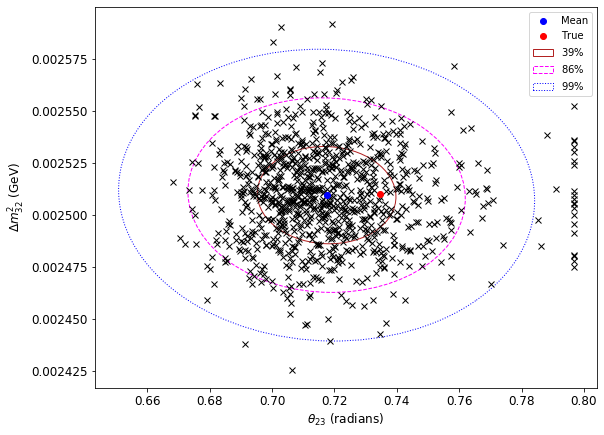

In [647]:
fig, ax = plt.subplots(figsize=(9, 7))

mu_Honda_nc = theta23_mean_Honda_nc, DM32_mean_Honda_nc
scale_Honda_nc = theta23_std_Honda_cc, DM32_std_Honda_nc

ax.plot(theta23_fits_Honda_nc, DM32_fits_Honda_nc, 'kx')

sigma1_contour_Honda_nc, _ = confidence_ellipse(theta23_fits_Honda_nc, DM32_fits_Honda_nc, ax, n_std=1,
                                                label=r'$39\%$', edgecolor='firebrick')
sigma2_contour_Honda_nc, _ = confidence_ellipse(theta23_fits_Honda_nc, DM32_fits_Honda_nc, ax, n_std=2,
                                                label=r'$86\%$', edgecolor='fuchsia', linestyle='--')
sigma3_contour_Honda_nc, _ = confidence_ellipse(theta23_fits_Honda_nc, DM32_fits_Honda_nc, ax, n_std=3,
                                                label=r'$99\%$', edgecolor='blue', linestyle=':')

ax.plot(mu_Honda_nc[0], mu_Honda_nc[1], 'bo', label='Mean')
ax.plot(theta23_true, DM32_true, 'ro', label='True')

ax.legend()
#ax.set_ylim(0.00248, 0.00254)
#ax.set_xlim(0.5, 0.9)
ax.set_xlabel(r'$\theta_{23}$ (radians)')
ax.set_ylabel(r'$\Delta m_{32}^2$ (GeV)')
#fig.savefig('Honda_cc_confidence')
plt.show()

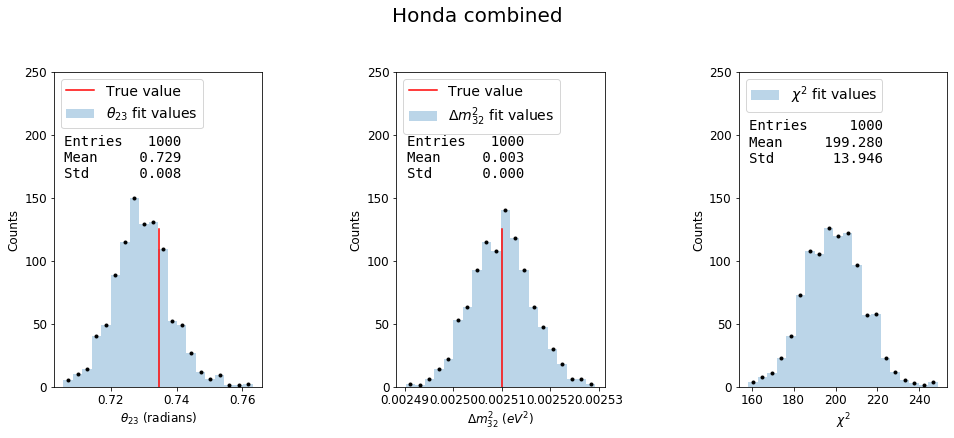

In [192]:
# combined fit of NC and CC

theta23_fits_Honda_tot, theta23_mean_Honda_tot, theta23_std_Honda_tot, DM32_fits_Honda_tot, DM32_mean_Honda_tot, DM32_std_Honda_tot = \
                                                                                                    fit_hist(1000, \
                                                                                                    [Honda_rate_cc, Honda_rate_nc], \
                                                                                                    [Honda_pseudo_data_cc, Honda_pseudo_data_nc], \
                                                                                                    'Honda combined')

In [452]:
# chi squared landscape Honda CC

def chi2_landscape(rate, pseudo, theta23, DM32):
    
    _, binned_prob = oop.prob_numu_numu(theta23, DM32)
    osc_rate = rate * binned_prob
    
    chi2 = np.sum(((osc_rate - pseudo)**2 / osc_rate))
    
    return chi2

In [638]:
N_landscape = 50
theta23_landscape_Honda_cc = np.linspace(np.sort(theta23_fits_Honda_cc)[0], np.sort(theta23_fits_Honda_cc)[-1], N_landscape)
DM32_landscape_Honda_cc = np.linspace(np.sort(DM32_fits_Honda_cc)[0], np.sort(DM32_fits_Honda_cc)[-1], N_landscape)

theta23_landscape_Honda_nc = np.linspace(np.sort(theta23_fits_Honda_nc)[0], np.sort(theta23_fits_Honda_nc)[-1], N_landscape)
DM32_landscape_Honda_nc = np.linspace(np.sort(DM32_fits_Honda_nc)[0], np.sort(DM32_fits_Honda_nc)[-1], N_landscape)

chi2_Honda_cc_mean = np.zeros((N_landscape, N_landscape))
chi2_Honda_nc_mean = np.zeros((N_landscape, N_landscape))

for n in range(10):
    Honda_fluct_cc = r.poisson(Honda_pseudo_data_cc)
    Honda_fluct_nc = r.poisson(Honda_pseudo_data_nc)
    
    #_, theta23_mean, _, _, _, _ = fit_hist(1, [Honda_rate_cc, Honda_rate_nc], [Honda_pseudo_data_cc, Honda_pseudo_data_nc], 'Honda combined')
    
    chi2_landscape_values_Honda_cc = np.zeros((N_landscape, N_landscape))
    chi2_landscape_values_Honda_nc = np.zeros((N_landscape, N_landscape))

    for t in range(N_landscape):
        for m in range(N_landscape):
            chi2_landscape_values_Honda_cc[m, t] = chi2_landscape(Honda_rate_cc, Honda_fluct_cc, 
                                                                  theta23_landscape_Honda_cc[t], DM32_landscape_Honda_cc[m])
            chi2_landscape_values_Honda_nc[m, t] = chi2_landscape(Honda_rate_nc, Honda_fluct_nc, 
                                                                  theta23_landscape_Honda_nc[t], DM32_landscape_Honda_nc[m])
    #print(chi2_landscape_values_Honda_nc.min())        
    chi2_Honda_cc_mean += chi2_landscape_values_Honda_cc
    chi2_Honda_nc_mean += chi2_landscape_values_Honda_nc
    
chi2_Honda_cc_mean /= 10
chi2_Honda_nc_mean /= 10


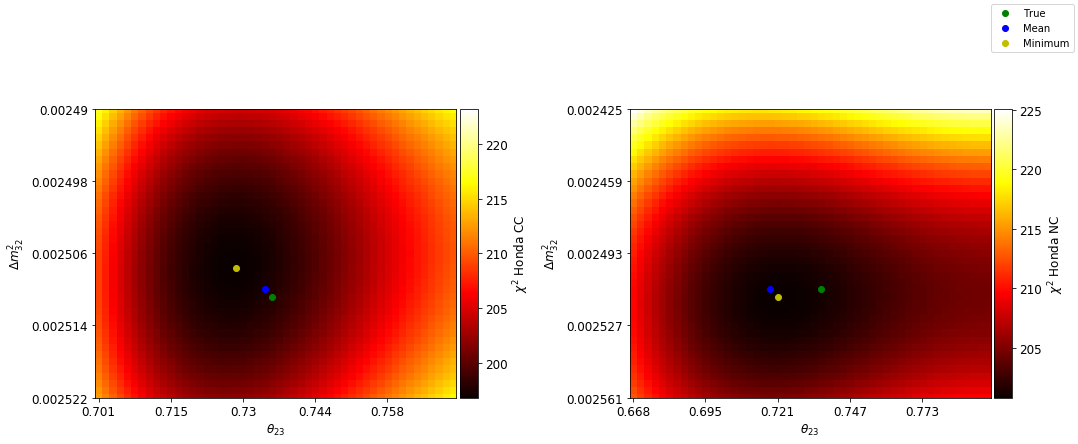

In [639]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))
ax.ravel()

im_cc = ax[0].imshow(chi2_Honda_cc_mean, cmap='hot')
divider_cc = make_axes_locatable(ax[0])
cax_cc = divider_cc.append_axes("right", size="5%", pad=0.05)
cbar_cc = plt.colorbar(im_cc, cax=cax_cc)
cbar_cc.set_label(r'$\chi^2$ Honda CC')

#chi2_landscape_values_Honda_nc_plot = chi2_landscape_values_Honda_nc.copy()[:,10:25]

im_nc = ax[1].imshow(chi2_Honda_nc_mean, cmap='hot')
divider_nc = make_axes_locatable(ax[1])
cax_nc = divider_nc.append_axes("right", size="5%", pad=0.05)
cbar_nc = plt.colorbar(im_nc, cax=cax_nc)
cbar_nc.set_label(r'$\chi^2$ Honda NC')

ax[0].plot(find_nearest_above(theta23_landscape_Honda_cc, theta23_true), 
           find_nearest_above(DM32_landscape_Honda_cc, DM32_true), 'go', label='True')
ax[0].plot(find_nearest_above(theta23_landscape_Honda_cc, theta23_mean_Honda_cc), 
           find_nearest_above(DM32_landscape_Honda_cc, DM32_mean_Honda_cc), 'bo', label='Mean')
ax[1].plot(find_nearest_above(theta23_landscape_Honda_nc, theta23_true), find_nearest_above(DM32_landscape_Honda_nc, DM32_true), 'go')
ax[1].plot(find_nearest_above(theta23_landscape_Honda_nc, theta23_mean_Honda_nc), 
           find_nearest_above(DM32_landscape_Honda_nc, DM32_mean_Honda_nc), 'bo')

chi2_Honda_cc_min = np.unravel_index(chi2_Honda_cc_mean.argmin(), chi2_Honda_cc_mean.shape)
chi2_Honda_nc_min = np.unravel_index(chi2_Honda_nc_mean.argmin(), chi2_Honda_nc_mean.shape)

ax[0].plot(chi2_Honda_cc_min[1], chi2_Honda_cc_min[0], 'yo', label='Minimum')
ax[1].plot(chi2_Honda_nc_min[1], chi2_Honda_nc_min[0], 'yo')

for n in range(2):
    ax[n].set_xlabel(r'$\theta_{23}$')
    ax[n].set_ylabel(r'$\Delta m^2_{32}$')
    ax[n].set_xticks(np.arange(0,N_landscape, 10))
    ax[n].set_yticks(np.arange(0,N_landscape, 10))
    

ax[0].set_xticklabels([f'{np.round(theta23_landscape_Honda_cc[i], 3)}' for i in np.arange(0,N_landscape, 10)])
ax[0].set_yticklabels([f'{np.round(DM32_landscape_Honda_cc[i], 6)}' for i in np.arange(0,N_landscape, 10)])
ax[1].set_xticklabels([f'{np.round(theta23_landscape_Honda_nc[i], 3)}' for i in np.arange(0,N_landscape, 10)])
ax[1].set_yticklabels([f'{np.round(DM32_landscape_Honda_nc[i], 6)}' for i in np.arange(0,N_landscape, 10)])
fig.legend()
plt.tight_layout();

# These means are from the histograms

In [461]:
print('CC min: theta23 =', theta23_landscape_Honda_cc[chi2_Honda_cc_min[1]], 'DM32 =',  DM32_landscape_Honda_cc[chi2_Honda_cc_min[0]])
print('Asimov: theta23 =', theta23_min_Honda_cc_asimov, 'DM32 =', DM32_min_Honda_cc_asimov)
print('NC min: theta23 =', theta23_landscape_Honda_nc[chi2_Honda_nc_min[1]], 'DM32 =',  DM32_landscape_Honda_nc[chi2_Honda_nc_min[0]])
print('Asimov: theta23 =', theta23_min_Honda_nc_asimov, 'DM32 =', DM32_min_Honda_nc_asimov)

CC min: theta23 = 0.7302192238288658 DM32 = 0.0025104289504475747
Asimov: theta23 = 0.7342562649045992 DM32 = 0.0025096496425046
NC min: theta23 = 0.7178887218521673 DM32 = 0.0025140008319175394
Asimov: theta23 = 0.7342337309684686 DM32 = 0.0025108681141273754


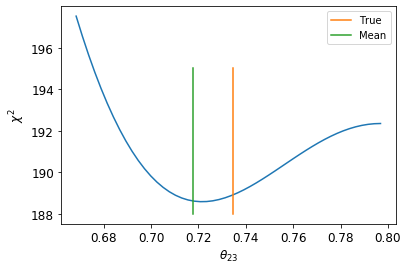

In [498]:
plt.plot(theta23_landscape_Honda_nc, chi2_Honda_nc_mean[find_nearest_above(DM32_landscape_Honda_nc, DM32_mean_Honda_nc),:])
plt.xlabel(r'$\theta_{23}$')
plt.ylabel(r'$\chi^2$')
plt.plot([theta23_true, theta23_true], [188,195], label='True')
plt.plot([theta23_mean_Honda_nc, theta23_mean_Honda_nc], [188,195], label='Mean')
plt.legend();

In [640]:
chi2_Honda_nc_mean_poisson = np.zeros((N_landscape, N_landscape))
chi2_Honda_nc_mean_normal = np.zeros((N_landscape, N_landscape))
chi2_Honda_nc_mean_uniform = np.zeros((N_landscape, N_landscape))

N = 50
theta23_poisson = np.zeros(N)
theta23_gauss = np.zeros(N)
theta23_uni = np.zeros(N)
DM32_poisson = np.zeros(N)
DM32_gauss = np.zeros(N)
DM32_uni = np.zeros(N)

for n in range(N):
    Honda_poisson_nc = r.poisson(Honda_pseudo_data_nc)
    Honda_normal_nc = r.normal(Honda_pseudo_data_nc)
    Honda_uniform_nc = Honda_pseudo_data_nc + r.uniform(-np.sqrt(Honda_pseudo_data_nc), np.sqrt(Honda_pseudo_data_nc))
    
    chi2_landscape_poisson_Honda_nc = np.zeros((N_landscape, N_landscape))
    chi2_landscape_normal_Honda_nc = np.zeros((N_landscape, N_landscape))
    chi2_landscape_uniform_Honda_nc = np.zeros((N_landscape, N_landscape))

    for t in range(N_landscape):
        for m in range(N_landscape):
            chi2_landscape_poisson_Honda_nc[m, t] = chi2_landscape(Honda_rate_nc, Honda_poisson_nc, 
                                                                  theta23_landscape_Honda_nc[t], DM32_landscape_Honda_nc[m])
            chi2_landscape_normal_Honda_nc[m, t] = chi2_landscape(Honda_rate_nc, Honda_normal_nc, 
                                                                  theta23_landscape_Honda_nc[t], DM32_landscape_Honda_nc[m])   
            chi2_landscape_uniform_Honda_nc[m, t] = chi2_landscape(Honda_rate_nc, Honda_uniform_nc, 
                                                                  theta23_landscape_Honda_nc[t], DM32_landscape_Honda_nc[m])       

    chi2_Honda_nc_mean_poisson += chi2_landscape_poisson_Honda_nc
    chi2_Honda_nc_mean_normal += chi2_landscape_normal_Honda_nc
    chi2_Honda_nc_mean_uniform += chi2_landscape_uniform_Honda_nc
    
            
    _, _, par_poisson, _ = chi_squared(oop.prob_numu_numu, [Honda_rate_nc], [Honda_poisson_nc], ['theta23', 'DM32'], [theta23_true, DM32_true])
    theta23_poisson[n] = par_poisson[0]
    DM32_poisson[n] = par_poisson[1]
    _, _, par_gauss, _ = chi_squared(oop.prob_numu_numu, [Honda_rate_nc], [Honda_normal_nc], ['theta23', 'DM32'], [theta23_true, DM32_true])
    theta23_gauss[n] = par_gauss[0]
    DM32_gauss[n] = par_gauss[1]
    _, _, par_uni, _ = chi_squared(oop.prob_numu_numu, [Honda_rate_nc], [Honda_uniform_nc], ['theta23', 'DM32'], [theta23_true, DM32_true])
    theta23_uni[n] = par_uni[0]
    DM32_uni[n] = par_uni[1]
    

chi2_Honda_nc_mean_poisson /= N
chi2_Honda_nc_mean_normal /= N
chi2_Honda_nc_mean_uniform /= N

theta23_poisson_mean = np.mean(theta23_poisson)
theta23_gauss_mean = np.mean(theta23_gauss)
theta23_uni_mean = np.mean(theta23_uni)
DM32_poisson_mean = np.mean(DM32_poisson)
DM32_gauss_mean = np.mean(DM32_gauss)
DM32_uni_mean = np.mean(DM32_uni)

chi2_Honda_nc_min_poisson = np.unravel_index(chi2_Honda_nc_mean_poisson.argmin(), chi2_Honda_nc_mean_poisson.shape)
poisson_theta_shift = theta23_min_Honda_nc_asimov - theta23_landscape_Honda_nc[chi2_Honda_nc_min_poisson[1]]

chi2_Honda_nc_min_normal = np.unravel_index(chi2_Honda_nc_mean_normal.argmin(), chi2_Honda_nc_mean_normal.shape)
normal_theta_shift = theta23_min_Honda_nc_asimov - theta23_landscape_Honda_nc[chi2_Honda_nc_min_normal[1]]

chi2_Honda_nc_min_uniform = np.unravel_index(chi2_Honda_nc_mean_uniform.argmin(), chi2_Honda_nc_mean_uniform.shape)
uniform_theta_shift = theta23_min_Honda_nc_asimov - theta23_landscape_Honda_nc[chi2_Honda_nc_min_uniform[1]]

print('Theta23 shift for poisson:', poisson_theta_shift, ', gauss:', normal_theta_shift, ', uniform:', uniform_theta_shift)

Theta23 shift for poisson: 0.1409853857569272 , gauss: 0.13049320111024454 , uniform: 0.13573929343358582


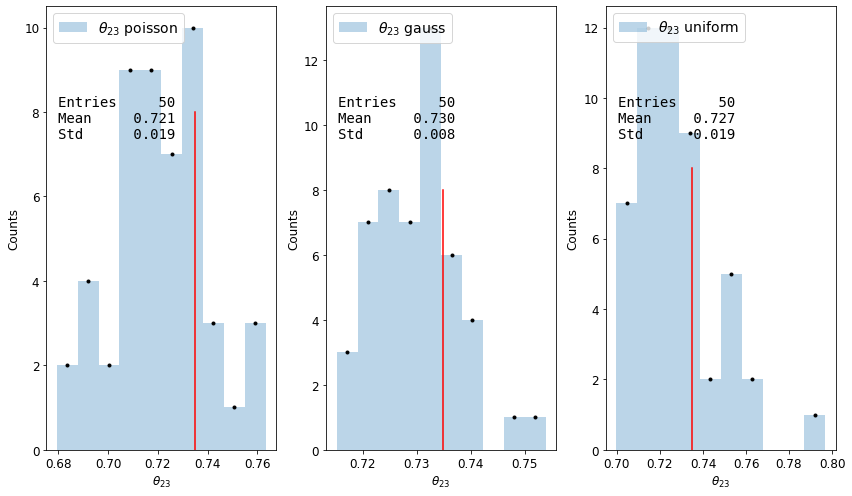

In [642]:
fig, axs = plt.subplots(1,3, figsize=(12,7))
axs.ravel()

cef.make_hist(axs[0], theta23_poisson, Nbins=10, loc_dic = (0.05, 0.8), label=(r'$\theta_{23}$ poisson', ''), errors = False)
cef.make_hist(axs[1], theta23_gauss, Nbins=10, loc_dic = (0.05, 0.8), label=(r'$\theta_{23}$ gauss', ''), errors = False)
cef.make_hist(axs[2], theta23_uni, Nbins=10, loc_dic = (0.05, 0.8), label=(r'$\theta_{23}$ uniform', ''), errors = False)

for i in range(3):
    axs[i].set_xlabel(r'$\theta_{23}$')
    axs[i].set_ylabel('Counts')
    axs[i].plot([theta23_true, theta23_true], [0,8], 'r-', label='True');

fig.tight_layout()

In [564]:
print('Min poisson fluctuations:', theta23_landscape_Honda_nc[chi2_Honda_nc_min_poisson[1]])
print('Min gauss fluctuations:', theta23_landscape_Honda_nc[chi2_Honda_nc_min_normal[1]])
print('Min uniform fluctuations:', theta23_landscape_Honda_nc[chi2_Honda_nc_min_uniform[1]])
print('True theta23:', theta23_true)

Min poisson fluctuations: 0.7129521953891191
Min gauss fluctuations: 0.7286904723591432
Min uniform fluctuations: 0.7286904723591432
True theta23: 0.7347836150896128


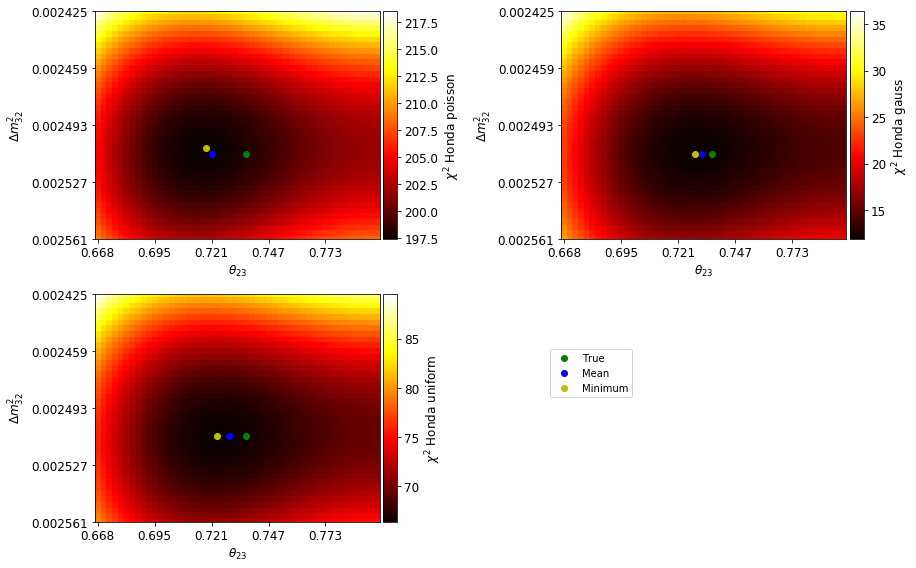

In [643]:
fig, ax = plt.subplots(2, 2, figsize=(13,8))
ax.ravel()

im_poisson = ax[0,0].imshow(chi2_Honda_nc_mean_poisson, cmap='hot')
divider_poisson = make_axes_locatable(ax[0,0])
cax_poisson = divider_poisson.append_axes("right", size="5%", pad=0.05)
cbar_poisson = plt.colorbar(im_poisson, cax=cax_poisson)
cbar_poisson.set_label(r'$\chi^2$ Honda poisson')

im_gauss = ax[0,1].imshow(chi2_Honda_nc_mean_normal, cmap='hot')
divider_gauss = make_axes_locatable(ax[0,1])
cax_gauss = divider_gauss.append_axes("right", size="5%", pad=0.05)
cbar_gauss = plt.colorbar(im_gauss, cax=cax_gauss)
cbar_gauss.set_label(r'$\chi^2$ Honda gauss')

im_uni = ax[1,0].imshow(chi2_Honda_nc_mean_uniform, cmap='hot')
divider_uni = make_axes_locatable(ax[1,0])
cax_uni = divider_uni.append_axes("right", size="5%", pad=0.05)
cbar_uni = plt.colorbar(im_uni, cax=cax_uni)
cbar_uni.set_label(r'$\chi^2$ Honda uniform')

ax[0,0].plot(find_nearest_above(theta23_landscape_Honda_nc, theta23_true), 
           find_nearest_above(DM32_landscape_Honda_nc, DM32_true), 'go', label='True')
ax[0,0].plot(find_nearest_above(theta23_landscape_Honda_nc, theta23_poisson_mean), 
           find_nearest_above(DM32_landscape_Honda_nc, DM32_poisson_mean), 'bo', label='Mean')
ax[0,1].plot(find_nearest_above(theta23_landscape_Honda_nc, theta23_true), 
           find_nearest_above(DM32_landscape_Honda_nc, DM32_true), 'go')
ax[0,1].plot(find_nearest_above(theta23_landscape_Honda_nc, theta23_gauss_mean), 
           find_nearest_above(DM32_landscape_Honda_nc, DM32_gauss_mean), 'bo')
ax[1,0].plot(find_nearest_above(theta23_landscape_Honda_nc, theta23_true), 
           find_nearest_above(DM32_landscape_Honda_nc, DM32_true), 'go')
ax[1,0].plot(find_nearest_above(theta23_landscape_Honda_nc, theta23_uni_mean), 
           find_nearest_above(DM32_landscape_Honda_nc, DM32_uni_mean), 'bo')

chi2_Honda_nc_min_poisson = np.unravel_index(chi2_Honda_nc_mean_poisson.argmin(), chi2_Honda_nc_mean_poisson.shape)
chi2_Honda_nc_min_gauss = np.unravel_index(chi2_Honda_nc_mean_normal.argmin(), chi2_Honda_nc_mean_normal.shape)
chi2_Honda_nc_min_uniform = np.unravel_index(chi2_Honda_nc_mean_uniform.argmin(), chi2_Honda_nc_mean_uniform.shape)

ax[0,0].plot(chi2_Honda_nc_min_poisson[1], chi2_Honda_nc_min_poisson[0], 'yo', label='Minimum')
ax[0,1].plot(chi2_Honda_nc_min_gauss[1], chi2_Honda_nc_min_gauss[0], 'yo')
ax[1,0].plot(chi2_Honda_nc_min_uniform[1], chi2_Honda_nc_min_uniform[0], 'yo')

for n in range(2):
    ax[0,n].set_xlabel(r'$\theta_{23}$')
    ax[0,n].set_ylabel(r'$\Delta m^2_{32}$')
    ax[0,n].set_xticks(np.arange(0,N_landscape, 10))
    ax[0,n].set_yticks(np.arange(0,N_landscape, 10))
    ax[0,n].set_xticklabels([f'{np.round(theta23_landscape_Honda_nc[i], 3)}' for i in np.arange(0,N_landscape, 10)])
    ax[0,n].set_yticklabels([f'{np.round(DM32_landscape_Honda_nc[i], 6)}' for i in np.arange(0,N_landscape, 10)])
    
ax[1,0].set_xlabel(r'$\theta_{23}$')
ax[1,0].set_ylabel(r'$\Delta m^2_{32}$')
ax[1,0].set_xticks(np.arange(0,N_landscape, 10))
ax[1,0].set_yticks(np.arange(0,N_landscape, 10))
ax[1,0].set_xticklabels([f'{np.round(theta23_landscape_Honda_nc[i], 3)}' for i in np.arange(0,N_landscape, 10)])
ax[1,0].set_yticklabels([f'{np.round(DM32_landscape_Honda_nc[i], 6)}' for i in np.arange(0,N_landscape, 10)])

fig.delaxes(ax[1,1])
fig.legend(loc=(0.6,0.3))
plt.tight_layout();

In [566]:
print(theta23_poisson_mean, theta23_gauss_mean, theta23_uni_mean, theta23_true)

0.7188491728397964 0.731230856831053 0.7302833345709548 0.7347836150896128


## MCEq 1D

In [32]:
MCEq_rate_cc = np.genfromtxt('MCEq_rate_spline_cc', delimiter=',')
MCEq_rate_nc = np.genfromtxt('MCEq_rate_spline_nc', delimiter=',')

MCEq_cc_oscillated = MCEq_rate_cc * binned_prob_true
MCEq_pseudo_data_cc = MCEq_cc_oscillated.copy()

MCEq_nc_oscillated = MCEq_rate_nc * binned_prob_true
MCEq_pseudo_data_nc = MCEq_nc_oscillated.copy()

In [ ]:
theta23_fits_MCEq_cc, theta23_mean_MCEq_cc, theta23_std_MCEq_cc, DM32_fits_MCEq_cc, DM32_mean_MCEq_cc, DM32_std_MCEq_cc = \
                                                                                                    fit_hist(N_runs, \
                                                                                                    [MCEq_rate_cc], \
                                                                                                    [MCEq_pseudo_data_cc], \
                                                                                                    'MCEq CC')

In [ ]:
theta23_fits_MCEq_nc, theta23_mean_MCEq_nc, theta23_std_MCEq_nc, DM32_fits_MCEq_nc, DM32_mean_MCEq_nc, DM32_std_MCEq_nc = \
                                                                                                    fit_hist(N_runs, \
                                                                                                    [MCEq_rate_nc], \
                                                                                                    [MCEq_pseudo_data_nc], \
                                                                                                    'MCEq NC')

In [ ]:
N_landscape = 50
theta23_landscape_MCEq_cc = np.linspace(np.sort(theta23_fits_MCEq_cc)[0], np.sort(theta23_fits_MCEq_cc)[-1], N_landscape)
DM32_landscape_MCEq_cc = np.linspace(np.sort(DM32_fits_MCEq_cc)[0], np.sort(DM32_fits_MCEq_cc)[-1], N_landscape)

theta23_landscape_MCEq_nc = np.linspace(np.sort(theta23_fits_MCEq_nc)[0], np.sort(theta23_fits_MCEq_nc)[-1], N_landscape)
DM32_landscape_MCEq_nc = np.linspace(np.sort(DM32_fits_MCEq_nc)[0], np.sort(DM32_fits_MCEq_nc)[-1], N_landscape)

chi2_MCEq_cc_mean = np.zeros((N_landscape, N_landscape))
chi2_MCEq_nc_mean = np.zeros((N_landscape, N_landscape))

for n in range(20):
    
    MCEq_fluct_cc = r.poisson(MCEq_pseudo_data_cc)
    MCEq_fluct_nc = r.poisson(MCEq_pseudo_data_nc)

    chi2_landscape_values_MCEq_cc = np.zeros((N_landscape, N_landscape))
    chi2_landscape_values_MCEq_nc = np.zeros((N_landscape, N_landscape))

    for t in range(N_landscape):
        for m in range(N_landscape):
            chi2_landscape_values_MCEq_cc[m, t] = chi2_landscape(MCEq_rate_cc, MCEq_fluct_cc, theta23_landscape_MCEq_cc[t], DM32_landscape_MCEq_cc[m])
            chi2_landscape_values_MCEq_nc[m, t] = chi2_landscape(MCEq_rate_nc, MCEq_fluct_nc, theta23_landscape_MCEq_nc[t], DM32_landscape_MCEq_nc[m])
            
    chi2_MCEq_cc_mean += chi2_landscape_values_MCEq_cc
    chi2_MCEq_nc_mean += chi2_landscape_values_MCEq_nc
    
chi2_MCEq_cc_mean /= 20
chi2_MCEq_nc_mean /= 20

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax.ravel()

im_cc = ax[0].imshow(chi2_MCEq_cc_mean, cmap='hot')
divider_cc = make_axes_locatable(ax[0])
cax_cc = divider_cc.append_axes("right", size="5%", pad=0.05)
cbar_cc = plt.colorbar(im_cc, cax=cax_cc)
cbar_cc.set_label(r'$\chi^2$ MCEq CC')

im_nc = ax[1].imshow(chi2_MCEq_nc_mean, cmap='hot')
divider_nc = make_axes_locatable(ax[1])
cax_nc = divider_nc.append_axes("right", size="5%", pad=0.05)
cbar_nc = plt.colorbar(im_nc, cax=cax_nc)
cbar_nc.set_label(r'$\chi^2$ MCEq NC')

ax[0].plot(find_nearest_above(theta23_landscape_MCEq_cc, theta23_true), find_nearest_above(DM32_landscape_MCEq_cc, DM32_true), 'go', label='True')
ax[1].plot(find_nearest_above(theta23_landscape_MCEq_nc, theta23_true), find_nearest_above(DM32_landscape_MCEq_nc, DM32_true), 'go')
ax[0].plot(find_nearest_above(theta23_landscape_MCEq_cc, theta23_mean_MCEq_cc), find_nearest_above(DM32_landscape_MCEq_cc, DM32_mean_MCEq_cc), 'bo', label='Mean')
ax[1].plot(find_nearest_above(theta23_landscape_MCEq_nc, theta23_mean_MCEq_nc), find_nearest_above(DM32_landscape_MCEq_nc, DM32_mean_MCEq_nc), 'bo')

chi2_MCEq_cc_min = np.unravel_index(chi2_MCEq_cc_mean.argmin(), chi2_MCEq_cc_mean.shape)
chi2_MCEq_nc_min = np.unravel_index(chi2_MCEq_nc_mean.argmin(), chi2_MCEq_nc_mean.shape)

ax[0].plot(chi2_MCEq_cc_min[1], chi2_MCEq_cc_min[0], 'yo', label='Minimum')
ax[1].plot(chi2_MCEq_nc_min[1], chi2_MCEq_nc_min[0], 'yo')

for n in range(2):
    ax[n].set_xlabel(r'$\theta_{23}$')
    ax[n].set_ylabel(r'$\Delta m^2_{32}$')
    ax[n].set_xticks(np.arange(0,N_landscape, 10))
    ax[n].set_yticks(np.arange(0,N_landscape, 10))
    

ax[0].set_xticklabels([f'{np.round(theta23_landscape_MCEq_cc[i], 3)}' for i in np.arange(0,N_landscape, 10)])
ax[0].set_yticklabels([f'{np.round(DM32_landscape_MCEq_cc[i], 5)}' for i in np.arange(0,N_landscape, 10)])
ax[1].set_xticklabels([f'{np.round(theta23_landscape_MCEq_nc[i], 3)}' for i in np.arange(0,N_landscape, 10)])
ax[1].set_yticklabels([f'{np.round(DM32_landscape_MCEq_nc[i], 5)}' for i in np.arange(0,N_landscape, 10)])
plt.tight_layout()
fig.legend();

## Honda fit with MCEq

In [33]:
# Non-fluctuated

Chi2_fit_HondatoMCEq_cc, Prob_fit_HondatoMCEq_cc, par_HondatoMCEq_cc, par_err_HondatoMCEq_cc = \
                                chi_squared(oop.prob_numu_numu, MCEq_rate_cc, Honda_pseudo_data_cc, 
                                ['theta23', 'DM32'], [theta23_true, DM32_true])

print('CC:')
print(f'theta23: {par_HondatoMCEq_cc[0]}, DM32: {par_HondatoMCEq_cc[1]}, chi^2: {Chi2_fit_HondatoMCEq_cc}')
print(f'True values: theta23: {theta23_true}, DM32: {DM32_true}')

Chi2_fit_HondatoMCEq_nc, Prob_fit_HondatoMCEq_nc, par_HondatoMCEq_nc, par_err_HondatoMCEq_nc = \
                                chi_squared(oop.prob_numu_numu, MCEq_rate_nc, Honda_pseudo_data_nc, 
                                ['theta23', 'DM32'], [theta23_true, DM32_true])

print('NC:')
print(f'theta23: {par_HondatoMCEq_nc[0]}, DM32: {par_HondatoMCEq_nc[1]}, chi^2: {Chi2_fit_HondatoMCEq_nc}')
print(f'True values: theta23: {theta23_true}, DM32: {DM32_true}')

CC:
theta23: 6.461898776535446e-08, DM32: 0.028587673937939134, chi^2: 214815.59842958293
True values: theta23: 0.7347836150896128, DM32: 0.00251
NC:
theta23: 1.544002917783405e-07, DM32: 11.004685526245174, chi^2: 23300.612150430934
True values: theta23: 0.7347836150896128, DM32: 0.00251


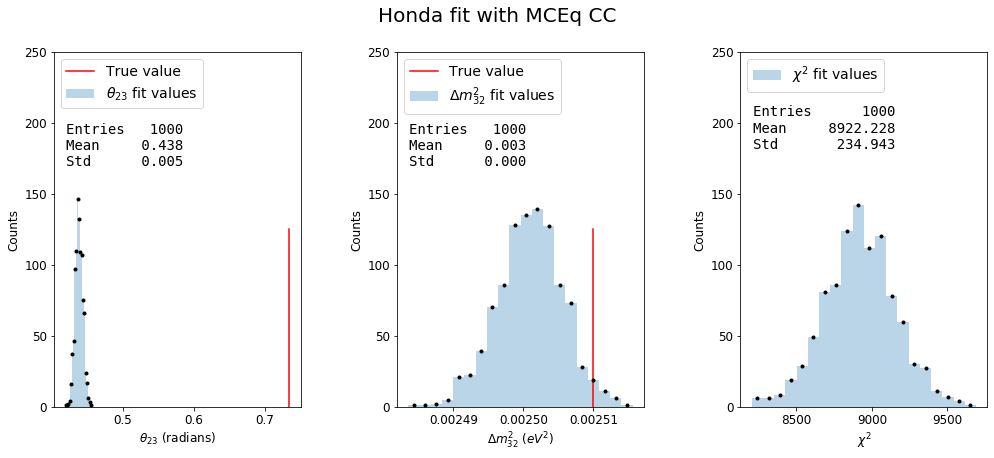

In [37]:
# fluctuated

theta23_fits_HondatoMCEq_cc, theta23_mean_HondatoMCEq_cc, theta23_std_HondatoMCEq_cc, DM32_fits_HondatoMCEq_cc, \
DM32_mean_HondatoMCEq_cc, DM32_std_HondatoMCEq_cc = fit_hist(1000, \
                                                    [MCEq_rate_cc], \
                                                    [Honda_pseudo_data_cc], \
                                                    'Honda fit with MCEq CC') #, savefig='HondatoMCEq_fits')

In [ ]:
fig, ax = plt.subplots(figsize=(9, 7))

mu_HondatoMCEq_cc = theta23_mean_HondatoMCEq_cc, DM32_mean_HondatoMCEq_cc
scale_HondatoMCEq_cc = theta23_std_HondatoMCEq_cc, DM32_std_HondatoMCEq_cc

ax.plot(theta23_fits_HondatoMCEq_cc, DM32_fits_HondatoMCEq_cc, 'kx')

sigma1_contour_HondatoMCEq_cc, _ = confidence_ellipse(theta23_fits_HondatoMCEq_cc, DM32_fits_HondatoMCEq_cc, ax, n_std=1,
                                                label=r'$1\sigma$', edgecolor='firebrick')
sigma2_contour_HondatoMCEq_cc, _ = confidence_ellipse(theta23_fits_HondatoMCEq_cc, DM32_fits_HondatoMCEq_cc, ax, n_std=2,
                                                label=r'$2\sigma$', edgecolor='fuchsia', linestyle='--')
sigma3_contour_HondatoMCEq_cc, _ = confidence_ellipse(theta23_fits_HondatoMCEq_cc, DM32_fits_HondatoMCEq_cc, ax, n_std=3,
                                                label=r'$3\sigma$', edgecolor='blue', linestyle=':')

ax.plot(mu_HondatoMCEq_cc[0], mu_HondatoMCEq_cc[1], 'bo', label='Mean')
ax.plot(theta23_true, DM32_true, 'ro', label='True')

ax.legend()
ax.set_ylim(0.00248, 0.00254)
ax.set_xlabel(r'$\theta_{23}$ (radians)')
ax.set_ylabel(r'$\Delta m_{32}^2$ (GeV)')
plt.show()

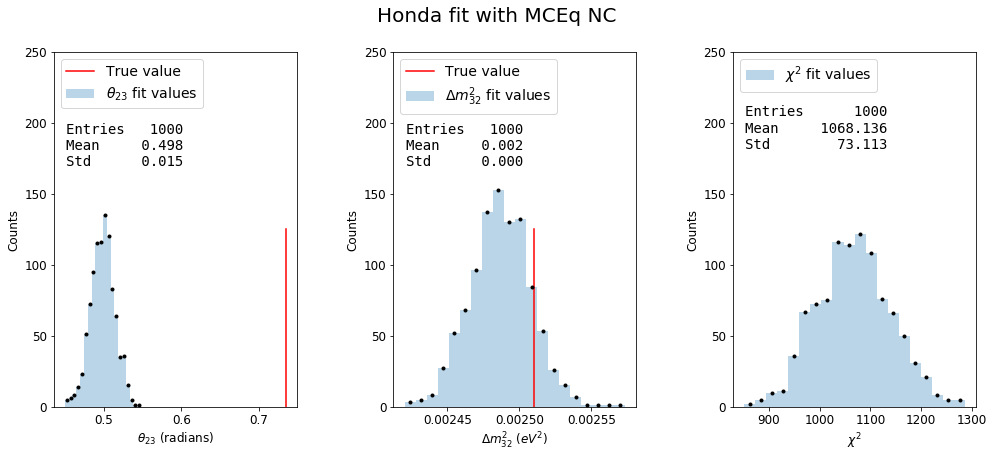

In [62]:
theta23_fits_HondatoMCEq_nc, theta23_mean_HondatoMCEq_nc, theta23_std_HondatoMCEq_nc, DM32_fits_HondatoMCEq_nc, \
DM32_mean_HondatoMCEq_nc, DM32_std_HondatoMCEq_nc = fit_hist(1000, \
                                                    [MCEq_rate_nc], \
                                                    [Honda_pseudo_data_nc], \
                                                    'Honda fit with MCEq NC')

## MCEq fit with Honda

In [48]:
# Non-fluctuated

Chi2_fit_MCEqtoHonda_cc, Prob_fit_MCEqtoHonda_cc, par_MCEqtoHonda_cc, par_err_MCEqtoHonda_cc = \
                                chi_squared(oop.prob_numu_numu, [Honda_rate_cc], [MCEq_pseudo_data_cc], 
                                ['theta23', 'DM32'], [theta23_true, DM32_true])

print('CC:')
print(f'theta23: {par_MCEqtoHonda_cc[0]}, DM32: {par_MCEqtoHonda_cc[1]}, chi^2: {Chi2_fit_MCEqtoHonda_cc}')
print(f'True values: theta23: {theta23_true}, DM32: {DM32_true}')

Chi2_fit_MCEqtoHonda_nc, Prob_fit_MCEqtoHonda_nc, par_MCEqtoHonda_nc, par_err_MCEqtoHonda_nc = \
                                chi_squared(oop.prob_numu_numu, [Honda_rate_nc], [MCEq_pseudo_data_nc], 
                                ['theta23', 'DM32'], [theta23_true, DM32_true])

print('NC:')
print(f'theta23: {par_MCEqtoHonda_nc[0]}, DM32: {par_MCEqtoHonda_nc[1]}, chi^2: {Chi2_fit_MCEqtoHonda_nc}')
print(f'True values: theta23: {theta23_true}, DM32: {DM32_true}')

CC:
theta23: 0.7968893716629903, DM32: 0.002565967773130154, chi^2: 7009.913588138104
True values: theta23: 0.7347836150896128, DM32: 0.00251
NC:
theta23: 0.7968893717334087, DM32: 0.0025688379927210196, chi^2: 633.3230902941001
True values: theta23: 0.7347836150896128, DM32: 0.00251


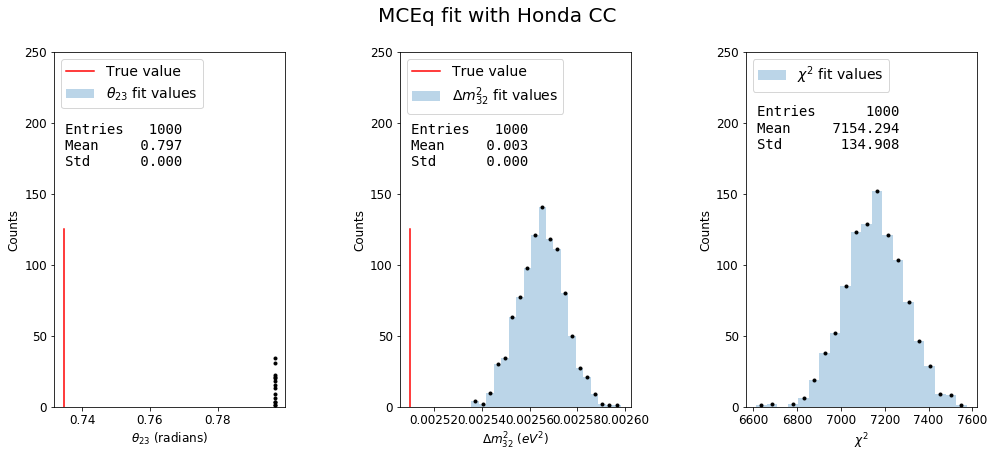

In [46]:
# fluctuated

theta23_fits_MCEqtoHonda_cc, theta23_mean_MCEqtoHonda_cc, theta23_std_MCEqtoHonda_cc, DM32_fits_MCEqtoHonda_cc, \
DM32_mean_MCEqtoHonda_cc, DM32_std_MCEqtoHonda_cc = fit_hist(1000, \
                                                    [Honda_rate_cc], \
                                                    [MCEq_pseudo_data_cc], \
                                                    'MCEq fit with Honda CC')

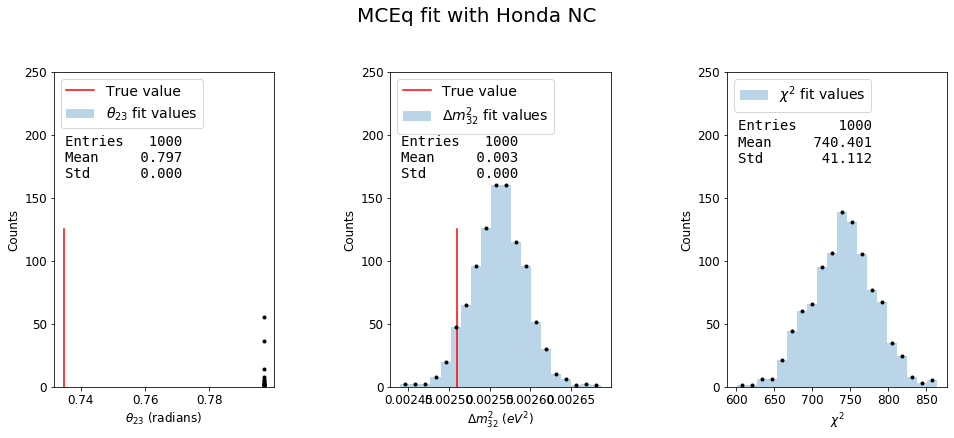

In [173]:
theta23_fits_MCEqtoHonda_nc, theta23_mean_MCEqtoHonda_nc, theta23_std_MCEqtoHonda_nc, DM32_fits_MCEqtoHonda_nc, \
DM32_mean_MCEqtoHonda_nc, DM32_std_MCEqtoHonda_nc = fit_hist(1000, \
                                                    [Honda_rate_nc], \
                                                    [MCEq_pseudo_data_nc], \
                                                    'MCEq fit with Honda NC')